**At-scale Model Output Statistics in mountain environments (AtsMOS) v1.0**

*Max Van Wyk de Vries, Tom Matthews, the AtsMOS team*

Problem: There is a need for an effective and computationally efficient method for downscaling coarse numerical model outputs to specific locations or areas of interest in mountainous environments.
 
Here we present the AtsMOS workflow which leverages advances in ML, data accessibility, and data interoperability to produce a flexible pipeline for correcting weather forecasts using ground data.

<div>
<img src="./workflow.png" width="650"/>
</div>
Workflow of the primary AtsMOS model stages


<div>
<img src="./figure_flow.png" width="650"/>
</div>

Stages to this code file:


**1 Load relevant packages**
------------------------------------------------------------------------------------
**2 Set up necessary functions**
------------------------------------------------------------------------------------
**3 Load datasets - both NWP model data and instrumental data**
------------------------------------------------------------------------------------
**4 Align all data to common time axis, and perform error checks**
------------------------------------------------------------------------------------
**5 Train ML models (here set up for continuous prediction with XGBoost)and save pretrained models**
------------------------------------------------------------------------------------
**6 Downoad up-to-date NWP data and process with pretrained ML model**
------------------------------------------------------------------------------------
**7 Create any plots of the data**
------------------------------------------------------------------------------------
**8 Save output data to interoperable MDF files**
------------------------------------------------------------------------------------

**Step 1: Load relevant packages**
------------------------------------------------------------------------------------

In [49]:
# Load relevant packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hydroeval as hy
import xarray as xr
import scipy
from scipy import stats
from datetime import datetime, timedelta
import pickle
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import RocCurveDisplay
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder


from matplotlib import cm
import statsmodels.api as sm

import sys, os

from time import sleep
import datetime as dt
import numpy.random as modnar # if needed for generating test data 
import netCDF4
from mdftoolkit.MDF_toolkit import MDF_toolkit as MDF
from mdftoolkit.MDF_toolkit import (# some helper functions
    df_from_ncfiles,
    printline
)

# Increase the size of plots from the default for visibility
plt.rcParams['figure.figsize'] = [10, 5]

#Suppress warnings (particularly useful where looped downloads can trigger many unnecessary warnings. May want to be commented out for diagnosing errors).
import warnings
warnings.filterwarnings("ignore")

**Step 2: Set up necessary functions**
------------------------------------------------------------------------------------


In [50]:
#Step 2: Set up necessary functions

#Note: ctrl-f the name of the function to see the different parts of the code they are used in. 
#A number of these functions are used throughout different sections, thus the collection here at the start.

########## MDF test functions

############ Miscellaneous processing functions
######## Define some necessary functions
def windget(u,v):
    #Create wind speed and wind direction
    wind_abs = np.sqrt(u*u + v*v)
    wind_dir = (270-np.rad2deg(np.arctan2(v,u))) % 360

    return(wind_abs,wind_dir)

def GFSresamp(tlag,GFSx):
    DF=GFSx;GFSxws,GFSxwd=windget(DF['Usummit'],DF['Vsummit'])
    D = pd.DataFrame()
    D['ws'+tlag] = GFSxws
    D['wd'+tlag] = GFSxwd
    D = D.set_index(pd.to_datetime(GFSx['forecast_time']))
    D = D[~D.index.duplicated()]
    D=D.resample('H').interpolate()
    D=D[(D.index > '2019-03-31 23:59')& (D.index < '2023-01-01')];
    return(D)

def dualcorrplot(label1,label2,cwindow,window,a,b,time):
    a.interpolate();b.interpolate()

    DF = pd.DataFrame()
    DF['a'] = a
    DF['b'] = b
    fig=plt.figure()
    ax1=fig.add_subplot(211)
    DF = DF.set_index(time)
    DF=DF.dropna()
    ax1.plot(DF.index,DF['a'].rolling(window).mean(), color="black",linewidth=0.5, label = label1)

    ax1.plot(DF.index,DF['b'].rolling(window).mean(), color="red",linewidth=0.5, label = label2)

    # ax1.gcf().autofmt_xdate()
    ax1.grid(linewidth = 0.5, alpha = 0.5)
    # ax1.title(title)
    ax1.set_ylabel("Wind speed (m/s)")
    ax1.legend()
    # ax1.set_xlim(['2019-01-01 00:00:00','2022-12-31 23:00:00'])

    ax2=fig.add_subplot(212)
    ds1=DF['a'];ds2=DF['b'];
    dts=DF.index;
    corr_roll=ds1.rolling(cwindow).corr(ds2,method='spearman');
    # print(corr_roll.dropna())

    DF=pd.DataFrame();DF['a']=corr_roll;DF=DF.set_index(dts);
    ax2.plot(DF.index,DF['a'].rolling(window).mean(), color="black");
    plt.gcf().autofmt_xdate();
    # ax2.title(title);
    ax2.set_ylabel('Correlation score');
    ax2.set_ylim([-1.1, 1.1]);ax2.grid(linewidth = 0.5, alpha = 0.5);
    plt.show

def mykge(simulations, evaluation):
    """Original Kling-Gupta Efficiency (KGE) and its three components
    (r, α, β) as per `Gupta et al., 2009
    <https://doi.org/10.1016/j.jhydrol.2009.08.003>`_.
    Note, all four values KGE, r, α, β are returned, in this order.
    :Calculation Details:
        .. math::
           E_{\\text{KGE}} = 1 - \\sqrt{[r - 1]^2 + [\\alpha - 1]^2
           + [\\beta - 1]^2}
        .. math::
           r = \\frac{\\text{cov}(e, s)}{\\sigma({e}) \\cdot \\sigma(s)}
        .. math::
           \\alpha = \\frac{\\sigma(s)}{\\sigma(e)}
        .. math::
           \\beta = \\frac{\\mu(s)}{\\mu(e)}
        where *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, *cov* is the covariance, *σ* is the
        standard deviation, and *μ* is the arithmetic mean.
    """
    # calculate error in timing and dynamics r
    # (Pearson's correlation coefficient)
    sim_mean = np.mean(simulations, axis=0)
    obs_mean = np.mean(evaluation)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0)
                    * np.sum((evaluation - obs_mean) ** 2))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0)
            / np.sum(evaluation))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return [kge_, r, alpha, beta]

def mykgesimple(simulations, evaluation,ovar):
    """Original Kling-Gupta Efficiency (KGE) and its three components
    (r, α, β) as per `Gupta et al., 2009
    <https://doi.org/10.1016/j.jhydrol.2009.08.003>`_.
    Note, all four values KGE, r, α, β are returned, in this order.
    :Calculation Details:
        .. math::
           E_{\\text{KGE}} = 1 - \\sqrt{[r - 1]^2 + [\\alpha - 1]^2
           + [\\beta - 1]^2}
        .. math::
           r = \\frac{\\text{cov}(e, s)}{\\sigma({e}) \\cdot \\sigma(s)}
        .. math::
           \\alpha = \\frac{\\sigma(s)}{\\sigma(e)}
        .. math::
           \\beta = \\frac{\\mu(s)}{\\mu(e)}
        where *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, *cov* is the covariance, *σ* is the
        standard deviation, and *μ* is the arithmetic mean.
    """
    # calculate error in timing and dynamics r
    # (Pearson's correlation coefficient)
    sim_mean = np.mean(simulations, axis=0)
    obs_mean = np.mean(evaluation)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0)
                    * np.sum((evaluation - obs_mean) ** 2))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0)
            / np.sum(evaluation))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    
    if ovar==1:
        kge_=kge_
    elif ovar==2:
        kge_=r
    elif ovar==3:
        kge_=alpha
    elif ovar==4:
        kge_=beta
        
        
    return kge_

def mynse(simulations, evaluation):
    """Nash-Sutcliffe Efficiency (NSE) as per `Nash and Sutcliffe, 1970
    <https://doi.org/10.1016/0022-1694(70)90255-6>`_.
    :Calculation Details:
        .. math::
           E_{\\text{NSE}} = 1 - \\frac{\\sum_{i=1}^{N}[e_{i}-s_{i}]^2}
           {\\sum_{i=1}^{N}[e_{i}-\\mu(e)]^2}
        where *N* is the length of the *simulations* and *evaluation*
        periods, *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, and *μ* is the arithmetic mean.
    """
    nse_ = 1 - (
            np.sum((evaluation - simulations) ** 2, axis=0)
            / np.sum((evaluation - np.mean(evaluation)) ** 2)
    )

    return nse_

def GFSresamp2(tlag,GFSx,GFSy):
    DF=GFSx
    GFSxws,GFSxwd=windget(DF['Usummit'],DF['Vsummit'])
    D = pd.DataFrame()
    D['ws'+tlag] = GFSxws
    D['wd'+tlag] = GFSxwd
    D = D.set_index(pd.to_datetime(GFSy['creation_time']))
    # plt.plot(D["ws0"]);plt.plot(dGFS12["ws12"]);plt.show()

    D = D[~D.index.duplicated()]
    D=D.resample('H').interpolate()
    D=D[(D.index > '2019-03-31 23:59')& (D.index < '2023-01-01')];
    return(D)

################### Define Model Output Statistics, Machine learning, and related plotting functions.

# Simple gridded plot
def MOSplot(data,model_corrected,time):
    fig=plt.figure()
    ax1=fig.add_subplot(211)
    ax1.plot(time,data,color='red',linewidth=0.5,label='Data')
    ax1.plot(time,model_corrected,color='black',linewidth=0.5,label='Model')
    ax1.grid(linewidth = 0.5, alpha = 0.5)
    ax1.set_ylabel("Wind speed (m/s)")
    plt.legend()
    
    ax2=fig.add_subplot(223)
    ax2.scatter(data,model_corrected,marker='+',linewidth=0.5,color='black',alpha=0.25)
    # ax2.plot(data,data,color='grey',linewidth=1,linestyle=':')
    ax2.grid(linewidth = 0.5, alpha = 0.5)
    ax2.set_ylabel("Model wind speed (m/s)")
    ax2.set_xlabel("Data wind speed (m/s)")
    
    ax3=fig.add_subplot(224)
    ax3.hexbin(data,model_corrected,bins=np.linspace(0,20),gridsize=50)
    # ax2.plot(range(0,round(varx[mask].max())),intercept[0]+range(0,round(varx[mask].max()))*slope[0], color="black")
    ax3.grid(linewidth = 0.5, alpha = 0.5)
    ax3.set_xlabel("Data wind speed (m/s)")
    plt.show()

#Plot of regression outputs
def regressplot(label1,label2,a,b,time):
    a.interpolate();b.interpolate()

    DF = pd.DataFrame()
    DF['a'] = a
    DF['b'] = b
    
    
    varx=DF['a']
    vary=DF['b']

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    x = sm.add_constant(varx[mask])
    model = sm.OLS(vary[mask],x)
    results = model.fit()
    slope[id]=results.params[1]
    intercept[id]=results.params[0]
    slope_unc[id]=results.bse[1]
    intercept_unc[id]=results.bse[0]
    
    fig=plt.figure()
    ax1=fig.add_subplot(131)
    ax1.scatter(varx[mask],vary[mask],marker='+',color="grey")
    # plt.hexbin(varx[mask],vary[mask],bins=np.linspace(1,50),gridsize=50)


    ax1.plot(range(0,round(varx[mask].max())),intercept[0]+range(0,round(varx[mask].max()))*slope[0], color="black")
    ax1.grid(linewidth = 0.5, alpha = 0.5);
    
    ax2=fig.add_subplot(132)
    # ax2.scatter(varx[mask],vary[mask],marker='+',color="grey")
    plt.hexbin(varx[mask],vary[mask],bins=np.linspace(1,50),gridsize=50)


    ax2.plot(range(0,round(varx[mask].max())),intercept[0]+range(0,round(varx[mask].max()))*slope[0], color="black")
    ax2.grid(linewidth = 0.5, alpha = 0.5);
    
    ax3=fig.add_subplot(133)
    ax3.hexbin(varx[mask],vary[mask]-(intercept[0]+varx[mask]*slope[0]),bins=np.linspace(0,50),gridsize=50)
    ax1.set_ylabel("Wind speed "+label1+" (m/s)")
    ax2.set_xlabel("Wind speed "+label2+" (m/s)")
    
    plt.show()
    
# Compute the statistics of a model output statistcs fit
def MOSstats(data,model_corrected):
    #Calculate key statistics: R2, RMSE, resid skew, resid kurtosis, MAE, slope, intercept, NSE, KGE, correlation, relvar, bias
    varx=data
    vary=model_corrected
    stats=[0]*12

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    x = sm.add_constant(varx[mask])
    model = sm.OLS(vary[mask],x)
    results = model.fit()
    
    stats[0]=results.rsquared
    # stats[1]=np.sqrt(results.mse_total)
    stats[1]=np.sqrt(np.mean((data - model_corrected)**2))
    stats[2]=skew(results.resid, axis=0, bias=True)
    stats[3]=kurtosis(results.resid, axis=0, bias=True)
    stats[4]= np.mean(abs(data - model_corrected))
    # stats[5]=results.params[1]
    # stats[6]=results.params[0]
        
    stats[7]=mynse(varx[mask],vary[mask]);

    kgeo=mykge(varx[mask],vary[mask])
    stats[8]=kgeo[0]
    stats[9]=kgeo[1]
    stats[10]=kgeo[2]
    stats[11]=kgeo[3]
    
    print('R2='+str(round(stats[0],2))+' RMSE='+str(round(stats[1],2))+' skew='+str(round(stats[2],2))+' kurtosis='+str(round(stats[3],2))+' MAE='+str(round(stats[4],2))+\
          # ' slope='+str(round(stats[5],2))+' intercept='+str(round(stats[6],2))+
          ' NSE='+str(round(stats[7],2))+' KGE='+str(round(stats[8],2))+' corr='+str(round(stats[9],2))+\
          ' relvar='+str(round(stats[10],2))+' bias='+str(round(stats[11],2)))

    return(stats)

#Linear regression calculation with test train split
def MOSlinregressTTS2(data_train,model_train,model_test,model_full):
    vary=data_train
    varx=model_train
    
    mask = ~np.isnan(varx) & ~np.isnan(vary)
    x = sm.add_constant(varx[mask])
    model = sm.OLS(vary[mask],x)
    results = model.fit()
        
    slope=results.params[0]
    intercept=results.params["const"]
    
    
    model_test=intercept+model_test*slope
    model_corrected=intercept+model_full*slope

#Simple mean bias correction
def MOSmeanbias(data,model):
    model_corrected = model+(data.mean()-model.mean())
    return(model_corrected)

#Simple mean bias correction with test and train split
def MOSmeanbiasTTS(data_train,model_train,model_test,model_full):
    model_corrected = model_full+(data_train.mean()-model_train.mean())
    model_test = model_test+(data_train.mean()-model_train.mean())
    return(model_test,model_corrected)

#Linear regression calculation with test train split
def MOSlinregressTTS(data_train,model_train,model_test,model_full):
    vary=data_train
    varx=model_train
    
    mask = ~np.isnan(varx) & ~np.isnan(vary)
    x = sm.add_constant(varx[mask])
    model = sm.OLS(vary[mask],x)
    results = model.fit()
        
    slope=results.params[1]
    intercept=results.params[0]
    
    
    model_test=intercept+model_test*slope
    model_corrected=intercept+model_full*slope
    return(model_test,model_corrected)

#Simple linear regression calculation
def MOSlinregress(data,model):
    vary=data
    varx=model
    
    mask = ~np.isnan(varx) & ~np.isnan(vary)
    x = sm.add_constant(varx[mask])
    model = sm.OLS(vary[mask],x)
    results = model.fit()
    slope=results.params[1]
    intercept=results.params[0]

    model_corrected=intercept+varx*slope
    return(model_corrected)

#Random forest based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
def MOSML_RF(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    
    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask].reshape(-1, 1)
    
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    
    rf.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_test[~np.isnan(model_test)] = rf.predict(np.array(model_test[~np.isnan(model_test)]).reshape(-1, 1))
    
    # Use the forest's predict method on the full data
    model_corrected=model_full
    model_corrected[~np.isnan(model_full)] = rf.predict(np.array(model_full[~np.isnan(model_full)]).reshape(-1, 1))

    return(model_test,model_corrected)

#Naive Bayes based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
#Poor results, not recommended
def MOSML_NB(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    
    vary=vary[mask].reshape(-1, 1).astype('int')
    varx=varx[mask].reshape(-1, 1).astype('int')
    
    gp=GaussianNB()
    
    gp.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_test[~np.isnan(model_test)] = gp.predict(np.array(model_test[~np.isnan(model_test)]).reshape(-1, 1))
    
    # Use the forest's predict method on the full data
    model_corrected=model_full
    model_corrected[~np.isnan(model_full)] = gp.predict(np.array(model_full[~np.isnan(model_full)]).reshape(-1, 1))

    return(model_test,model_corrected)

#Gaussian Process model based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
#Poor results, not recommended
def MOSML_GP(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    
    vary=vary[mask].reshape(-1, 1).astype('int')
    varx=varx[mask].reshape(-1, 1).astype('int')
    
    gp=  GaussianProcessClassifier(1.0 * RBF(1.0), random_state = 42)
    
    gp.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_test[~np.isnan(model_test)] = gp.predict(np.array(model_test[~np.isnan(model_test)]).reshape(-1, 1))
    
    # Use the forest's predict method on the full data
    model_corrected=model_full
    model_corrected[~np.isnan(model_full)] = gp.predict(np.array(model_full[~np.isnan(model_full)]).reshape(-1, 1))

    return(model_test,model_corrected)

#Neural network (Simple multilayer perceptron) based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
#See MOSLK_NN2 for a modified neural net with better performance but slower computation
def MOSML_NN(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    
    vary=vary[mask].reshape(-1, 1).astype('int')
    varx=varx[mask].reshape(-1, 1).astype('int')
    
    nn=MLPClassifier(alpha=1, max_iter=1000, random_state = 42)
    
    nn.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_test[~np.isnan(model_test)] = nn.predict(np.array(model_test[~np.isnan(model_test)]).reshape(-1, 1))
    
    # Use the forest's predict method on the full data
    model_corrected=model_full
    model_corrected[~np.isnan(model_full)] = nn.predict(np.array(model_full[~np.isnan(model_full)]).reshape(-1, 1))

    return(model_test,model_corrected)

#Neural network (Modified multilayer perceptron) based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
def MOSML_NN2(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = MLPClassifier(activation='relu',alpha=0.0001,hidden_layer_sizes=(10,10,10,100,100,1000,1000,100,100,10,10,10), max_iter=1000, random_state = 42)

    rf.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_testt=model_test.iloc[:,1]
    model_testt[~np.any(np.isnan(np.array(model_test)),axis=1)] = rf.predict(np.array(model_test[~np.any(np.isnan(np.array(model_test)),axis=1)]))#.reshape(-1, 1))

    # Use the forest's predict method on the full data
    model_correctedt=model_full.iloc[:,1]
    model_correctedt[~np.any(np.isnan(np.array(model_full)),axis=1)] = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))

    return(model_testt,model_correctedt)

#ADA boost based Machine Learning MOS with test train split
# single timeseries input (not multivariate)
#Poor results, not recommended
def MOSML_ADA(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.isnan(varx) & ~np.isnan(vary)
    
    vary=vary[mask].reshape(-1, 1).astype('int')
    varx=varx[mask].reshape(-1, 1).astype('int')
    
    ada= AdaBoostClassifier(random_state = 42)
    
    ada.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_test[~np.isnan(model_test)] = ada.predict(np.array(model_test[~np.isnan(model_test)]).reshape(-1, 1))
    
    # Use the forest's predict method on the full data
    model_corrected=model_full
    model_corrected[~np.isnan(model_full)] = ada.predict(np.array(model_full[~np.isnan(model_full)]).reshape(-1, 1))

    return(model_test,model_corrected)

#Random Forest based Machine Learning MOS with test train split
# multivariate data input is acceptable
def MOSML_RF2(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

    rf.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_testt=model_test.iloc[:,1]
    model_testt[~np.any(np.isnan(np.array(model_test)),axis=1)] = rf.predict(np.array(model_test[~np.any(np.isnan(np.array(model_test)),axis=1)]))#.reshape(-1, 1))

    # Use the forest's predict method on the full data
    model_correctedt=model_full.iloc[:,1]
    model_correctedt[~np.any(np.isnan(np.array(model_full)),axis=1)] = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))

    return(model_testt,model_correctedt)

#Multiple linear regression based "Machine Learning" MOS with test train split
# single timeseries input (not multivariate)
#Poor results, not recommended
def MOSML_MLR(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    regr = linear_model.LinearRegression()

    regr.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_testt=model_test.iloc[:,1]
    model_testt[~np.any(np.isnan(np.array(model_test)),axis=1)] = regr.predict(np.array(model_test[~np.any(np.isnan(np.array(model_test)),axis=1)])).flatten()

    # Use the forest's predict method on the full data
    model_correctedt=model_full.iloc[:,1]
    model_correctedt[~np.any(np.isnan(np.array(model_full)),axis=1)] = regr.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)])).flatten()

    return(model_testt,model_correctedt)

def MOSML_XGB(data_train,model_train,model_test,model_full):
    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    bst = XGBRegressor(
         seed=0, #Seed for reproducibility
         learning_rate =0.1,n_estimators=250,max_depth=4, #Key parameters
         min_child_weight=6,gamma=0,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.005,scale_pos_weight=1, #Secondary parameters
         objective= 'reg:squarederror' #Objective function
         )
    
    # le = LabelEncoder()
    # vary = le.fit_transform(vary)

    bst.fit(varx,vary)

    # Use the forest's predict method on the test data
    model_testt=model_test.iloc[:,1]
    model_testt[~np.any(np.isnan(np.array(model_test)),axis=1)] = bst.predict(np.array(model_test[~np.any(np.isnan(np.array(model_test)),axis=1)])).flatten()

    # Use the forest's predict method on the full data
    model_correctedt=model_full.iloc[:,1]
    model_correctedt[~np.any(np.isnan(np.array(model_full)),axis=1)] = bst.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)])).flatten()

    return(model_testt,model_correctedt)


# Updated plot of results
def MOSplot2(datafull,data,model_corrected,time):
    fig=plt.figure()
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.plot(time,model_corrected,color='red',linewidth=0.5,label='Prediction')
    ax1.grid(linewidth = 0.5, alpha = 0.5)
    ax1.set_ylabel("Probability of winds above threshold")
    ax1.fill_between(
        x= time, 
        y1= model_corrected, 
        color= "r",
        alpha= 0.2)
    
    
    ax2.plot(time,datafull,color='black',linewidth=0.5,label='Data')
    ax2.grid(linewidth = 0.5, alpha = 0.5)
    ax2.set_ylabel("Data wind speed (m/s)")
    # ax1.legend()
    # ax2.legend()
    plt.show()
    
    #Plot ROC curve
    mask = ~np.isnan(data) & ~np.isnan(model_corrected)
    
    RocCurveDisplay.from_predictions(
    data[mask],
    model_corrected[mask],
    name="t vs the rest",
    color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

#Categorical machine learning MOS function with multivariate input
#Can be used with either the random forest ('RF') or Neural Network ('NN')
#Test train split is used
#Note the requirement for a threshold to control the categorical binarization
def categoricalML(full,f0,thresh,rollwin,varname,MLmethod):
    #Inputs: data array, predictor variables, wind threshold, rolling max window, variable name, method
    p1t=pd.to_datetime(['2019-01-01','2021-01-01'])
    p2t=pd.to_datetime(['2021-01-01','2023-01-01'])
    p1=full[(full.index > p1t[0])& (full.index < p1t[1])]
    p2=full[(full.index > p2t[0])& (full.index < p2t[1])]
    p1f0=f0[(f0.index > p1t[0])& (f0.index < p1t[1])]
    p2f0=f0[(f0.index > p2t[0])& (f0.index < p2t[1])]

    data_test=p2["predictor_avg"].ge(thresh).astype(int).rolling(rollwin,center=False).max(); data_test[pd.isna(p2["predictor_avg"])]=np.nan
    model_test=p2f0.iloc[:,1:]
    model_full=f0.iloc[:,1:]
    data_train=p1["predictor_avg"].ge(thresh).astype(int).rolling(rollwin,center=False).max() ; data_train[pd.isna(p1["predictor_avg"])]=np.nan
    model_train=p1f0.iloc[:,1:]
    
    if MLmethod=="RF":
        p2[varname+str(thresh)+"1"],full[varname+str(thresh)+"1"]=MOSML_RF2(data_train,model_train,model_test,model_full)
    elif MLmethod=="NN":
        p2[varname+str(thresh)+"1"],full[varname+str(thresh)+"1"]=MOSML_NN2(data_train,model_train,model_test,model_full)
        
    MOSplot2(p2["predictor_avg"],data_test,p2[varname+str(thresh)+"1"],p2.index)

    data_test=p1["predictor_avg"].ge(30).astype(int).rolling(rollwin,center=False).max() ; data_test[pd.isna(p1["predictor_avg"])]=np.nan
    model_test=p1f0.iloc[:,1:]
    model_full=f0.iloc[:,1:]
    data_train=p2["predictor_avg"].ge(30).astype(int).rolling(rollwin,center=False).max(); data_train[pd.isna(p2["predictor_avg"])]=np.nan
    model_train=p2f0.iloc[:,1:]
    
    if MLmethod=="RF":
        p1[varname+str(thresh)+"2"],full[varname+str(thresh)+"2"]=MOSML_RF2(data_train,model_train,model_test,model_full)
    elif MLmethod=="NN":
        p1[varname+str(thresh)+"2"],full[varname+str(thresh)+"2"]=MOSML_NN2(data_train,model_train,model_test,model_full)
        
    MOSplot2(p1["predictor_avg"],data_test,p1[varname+str(thresh)+"2"],p1.index)
    return(full)


#Updated categorical machine learning MOS function with multivariate input
#Can be used with either the random forest ('RF') or Neural Network ('NN')
#Test train split is NOT used - train on full timeseries
#Note the requirement for a threshold to control the categorical binarization
def categoricalML2(full,f0,real,thresh,rollwin):

    # data_test=p1["predictor_avg"].le(thresh).astype(int).rolling(rollwin,center=False).mean() ; data_test[pd.isna(p1["predictor_avg"])]=np.nan
    # model_test=p1f0.iloc[:,1:]
    model_full=real.iloc[:,1:]
    data_train=full["predictor_avg"].ge(thresh).astype(int).rolling(rollwin,center=False).max(); 
    data_train[pd.isna(full["predictor_avg"])]=np.nan
    model_train=f0.iloc[:,1:]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 100, random_state = 5)

    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))

        
    return(prediction)

def categoricalML_XGB(full,f0,real,thresh,rollwin):

    # data_test=p1["predictor_avg"].le(thresh).astype(int).rolling(rollwin,center=False).mean() ; data_test[pd.isna(p1["predictor_avg"])]=np.nan
    # model_test=p1f0.iloc[:,1:]
    model_full=real.iloc[:,1:]
    data_train=full["predictor_avg"].ge(thresh).astype(int).rolling(rollwin,center=False).max(); 
    data_train[pd.isna(full["predictor_avg"])]=np.nan
    model_train=f0.iloc[:,1:]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    bst = XGBClassifier(
         seed=0, #Seed for reproducibility
         learning_rate =0.1,n_estimators=250,max_depth=4, #Key parameters
         min_child_weight=6,gamma=0,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.005,scale_pos_weight=1, #Secondary parameters
         objective= 'binary:logistic' #Objective function
         )

    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))

        
    return(prediction)

#Simple multivariate Random Forest based continuous prediction
#Test train split is NOT used - train on full timeseries
def contiML2(full,f0,real):

    model_full=real.iloc[:,1:]
    data_train=full["predictor_avg"]; 
    data_train[pd.isna(full["predictor_avg"])]=np.nan
    model_train=f0.iloc[:,1:]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)

    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))

        
    return(prediction)


def contiML_XGB(full,f0,real):

    model_full=real.iloc[:,1:]
    data_train=full["predictor_avg"]; 
    data_train[pd.isna(full["predictor_avg"])]=np.nan
    model_train=f0.iloc[:,1:]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    bst = XGBRegressor(
         seed=0, #Seed for reproducibility
         learning_rate =0.1,n_estimators=250,max_depth=4, #Key parameters
         min_child_weight=6,gamma=0,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.005,scale_pos_weight=1, #Secondary parameters
         objective= 'reg:squarederror' #Objective function
         )
 
    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))

        
    return(prediction)

################# Function to get real-time GFS data from the NCAR THREDDS server and compute all
# derivative variables used in the multivariatemachine learning
def getdatcurrent(offsettime):

    #Define latitude and longitude bounds. Note min and max can be the same for a point.
    maxlat=29
    minlat=27
    maxlon=88
    minlon=86

    #Define variables of interest (see full list below)
    varibls=['u-component_of_wind_isobaric', 'Temperature_isobaric', 'Ozone_Mixing_Ratio_isobaric',\
             'Vertical_velocity_pressure_isobaric', 'Relative_humidity_isobaric', 'v-component_of_wind_isobaric', 'Geopotential_height_isobaric',\
             'Cloud_mixing_ratio_isobaric', 'Absolute_vorticity_isobaric']

    url = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/TwoD"
    ds = xr.open_dataset(url)
    # data2=ds[varibls].sel(lon=np.arange(minlon, maxlon+0.001, 0.25), lat=np.arange(minlat, maxlat+0.001, 0.25),\
    #                       isobaric=[3.00e+04, 3.50e+04, 4.00e+04], isobaric1=[30000.,  35000.,  40000],timeOffset=[offsettime])
    
    
    # print(ds[varibls])
    data2=ds[varibls].sel(lon=np.arange(minlon, maxlon+0.001, 0.25), lat=np.arange(minlat, maxlat+0.001, 0.25),\
                      isobaric=[3.00e+04, 3.50e+04, 4.00e+04], isobaric1=[30000.,  35000.,  40000])#,validtime2Offset=[offsettime])
    if 'validtime1Offset' in data2.coords:
        data2=data2.rename({'validtime1Offset':'validtimeOffset'})
    if 'validtime2Offset' in data2.coords:
        data2=data2.rename({'validtime2Offset':'validtimeOffset'})
    if 'validtime3Offset' in data2.coords:
        data2=data2.rename({'validtime3Offset':'validtimeOffset'})
    if 'validtime4Offset' in data2.coords:
        data2=data2.rename({'validtime4Offset':'validtimeOffset'})
    if 'validtime5Offset' in data2.coords:
        data2=data2.rename({'validtime5Offset':'validtimeOffset'})
    if 'timeOffset' in data2.coords:
        data2=data2.rename({'timeOffset':'validtimeOffset'})

    
    data2=data2.sel(validtimeOffset=[offsettime])
    
        
        
    # print(data2)
    dat_current = pd.DataFrame();

    dat_current['timax']=pd.to_datetime(data2.coords['reftime'].values)+ timedelta(hours=offsettime);

    t1=np.array(data2.variables['Geopotential_height_isobaric'].values)

    dat_current['GPH300']=t1[:,:,0,4,4];
    dat_current['GPH350']=t1[:,:,1,4,4];
    dat_current['GPH400']=t1[:,:,2,4,4];

    dat_current['GPH300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['GPH300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['GPH300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['GPH300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['GPH350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['GPH350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['GPH350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['GPH350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['GPH400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['GPH400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['GPH400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['GPH400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    dat_current['GPHzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['GPHzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['GPHzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['GPHzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['GPHzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['GPHzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);

    GPHratio=(t1[:,:,0,4,4]-8849)/(t1[:,:,0,4,4]-t1[:,:,1,4,4]);
    GPHratio=np.squeeze(GPHratio)

    t1=np.array(data2.variables['Relative_humidity_isobaric'].values)

    dat_current['RH300']=t1[:,:,0,4,4];
    dat_current['RH350']=t1[:,:,1,4,4];
    dat_current['RH400']=t1[:,:,2,4,4];

    dat_current['RHsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    t1=np.array(data2.variables['Cloud_mixing_ratio_isobaric'].values)

    dat_current['CLWMR300']=t1[:,:,0,4,4];
    dat_current['CLWMR350']=t1[:,:,1,4,4];
    dat_current['CLWMR400']=t1[:,:,2,4,4];

    dat_current['CLWMRsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    t1=np.array(data2.variables['Vertical_velocity_pressure_isobaric'].values)

    dat_current['VertVelo300']=t1[:,:,0,4,4];
    dat_current['VertVelo350']=t1[:,:,1,4,4];
    dat_current['VertVelo400']=t1[:,:,2,4,4];

    dat_current['VertVelosummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    t1=np.array(data2.variables['Absolute_vorticity_isobaric'].values)

    dat_current['AbsVort300']=t1[:,:,0,4,4];
    dat_current['AbsVort350']=t1[:,:,1,4,4];
    dat_current['AbsVort400']=t1[:,:,2,4,4];

    dat_current['AbsVortsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    t1=np.array(data2.variables['Ozone_Mixing_Ratio_isobaric'].values)

    dat_current['O3MX300']=t1[:,:,0,4,4];
    dat_current['O3MX350']=t1[:,:,1,4,4];
    dat_current['O3MX400']=t1[:,:,2,4,4];

    dat_current['O3MXsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])


    t1=np.array(data2.variables['Temperature_isobaric'].values)

    dat_current['T300']=t1[:,:,0,4,4];
    dat_current['T350']=t1[:,:,1,4,4];
    dat_current['T400']=t1[:,:,2,4,4];
    dat_current['Tsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    dat_current['T300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['T300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['T300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['T300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['T350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['T350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['T350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['T350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['T400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['T400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['T400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['T400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    t1_summit = (1-np.tile(GPHratio[:, None, None], [1, 9, 9]))*t1[:,0,0,:,:]+\
        np.tile(GPHratio[:, None, None], [1, 9, 9])*t1[:,0,0,:,:];

    dat_current['Tsummitxgrad3']=t1_summit[:,4,3]-t1_summit[:,4,5];
    dat_current['Tsummitxgrad9']=t1_summit[:,4,1]-t1_summit[:,4,8];
    dat_current['Tsummitygrad3']=t1_summit[:,3,4]-t1_summit[:,5,4];
    dat_current['Tsummitygrad9']=t1_summit[:,1,4]-t1_summit[:,8,4];

    dat_current['Tzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['Tzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['Tzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['Tzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['Tzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['Tzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);


    t1=np.array(data2.variables['u-component_of_wind_isobaric'].values)

    dat_current['Uwind300']=t1[:,:,0,4,4];
    dat_current['Uwind350']=t1[:,:,1,4,4];
    dat_current['Uwind400']=t1[:,:,2,4,4];
    dat_current['Uwindsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    dat_current['Uwind300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['Uwind300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['Uwind300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['Uwind300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['Uwind350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['Uwind350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['Uwind350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['Uwind350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['Uwind400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['Uwind400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['Uwind400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['Uwind400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    t1_summit = (1-np.tile(GPHratio[:, None, None], [1, 9, 9]))*t1[:,0,0,:,:]+\
        np.tile(GPHratio[:, None, None], [1, 9, 9])*t1[:,0,0,:,:];

    u_summit = (1-np.tile(GPHratio[:, None, None], [1, 9, 9]))*t1[:,0,0,:,:]+\
        np.tile(GPHratio[:, None, None], [1, 9, 9])*t1[:,0,0,:,:];

    dat_current['Uwindsummitxgrad3']=t1_summit[:,4,3]-t1_summit[:,4,5];
    dat_current['Uwindsummitxgrad9']=t1_summit[:,4,1]-t1_summit[:,4,8];
    dat_current['Uwindsummitygrad3']=t1_summit[:,3,4]-t1_summit[:,5,4];
    dat_current['Uwindsummitygrad9']=t1_summit[:,1,4]-t1_summit[:,8,4];

    dat_current['Uwindzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['Uwindzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['Uwindzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['Uwindzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['Uwindzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['Uwindzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);


    t1=np.array(data2.variables['v-component_of_wind_isobaric'].values)

    dat_current['Vwind300']=t1[:,:,0,4,4];
    dat_current['Vwind350']=t1[:,:,1,4,4];
    dat_current['Vwind400']=t1[:,:,2,4,4];
    dat_current['Vwindsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    dat_current['Vwind300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['Vwind300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['Vwind300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['Vwind300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['Vwind350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['Vwind350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['Vwind350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['Vwind350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['Vwind400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['Vwind400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['Vwind400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['Vwind400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    t1_summit = (1-np.tile(GPHratio[:, None, None], [1, 9, 9]))*t1[:,0,0,:,:]+\
        np.tile(GPHratio[:, None, None], [1, 9, 9])*t1[:,0,0,:,:];

    v_summit = (1-np.tile(GPHratio[:, None, None], [1, 9, 9]))*t1[:,0,0,:,:]+\
        np.tile(GPHratio[:, None, None], [1, 9, 9])*t1[:,0,0,:,:];

    dat_current['Vwindsummitxgrad3']=t1_summit[:,4,3]-t1_summit[:,4,5];
    dat_current['Vwindsummitxgrad9']=t1_summit[:,4,1]-t1_summit[:,4,8];
    dat_current['Vwindsummitygrad3']=t1_summit[:,3,4]-t1_summit[:,5,4];
    dat_current['Vwindsummitygrad9']=t1_summit[:,1,4]-t1_summit[:,8,4];

    dat_current['Vwindzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['Vwindzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['Vwindzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['Vwindzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['Vwindzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['Vwindzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);


    uu=np.array(data2.variables['u-component_of_wind_isobaric'].values)
    vv=np.array(data2.variables['v-component_of_wind_isobaric'].values)

    def cart2pol(x, y):
        rho = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y, x)
        return(rho, phi)

    wss,wdd = cart2pol(uu, vv)

    wdd = ((270-(180*wdd/3.141592)) % 360);

    wss_summit,wdd_summit = cart2pol(u_summit, v_summit)

    wdd_summit = ((270-(180*wdd_summit/3.141592)) % 360);



    t1=wdd

    dat_current['WD300']=t1[:,:,0,4,4];
    dat_current['WD350']=t1[:,:,1,4,4];
    dat_current['WD400']=t1[:,:,2,4,4];
    dat_current['WDsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    dat_current['WD300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['WD300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['WD300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['WD300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['WD350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['WD350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['WD350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['WD350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['WD400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['WD400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['WD400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['WD400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    t1_summit = wdd_summit

    dat_current['WDsummitxgrad3']=t1_summit[:,4,3]-t1_summit[:,4,5];
    dat_current['WDsummitxgrad9']=t1_summit[:,4,1]-t1_summit[:,4,8];
    dat_current['WDsummitygrad3']=t1_summit[:,3,4]-t1_summit[:,5,4];
    dat_current['WDsummitygrad9']=t1_summit[:,1,4]-t1_summit[:,8,4];

    dat_current['WDzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['WDzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['WDzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['WDzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['WDzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['WDzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);


    t1=wss

    dat_current['WS300']=t1[:,:,0,4,4];
    dat_current['WS350']=t1[:,:,1,4,4];
    dat_current['WS400']=t1[:,:,2,4,4];
    dat_current['WSsummit']=(1-GPHratio)*np.squeeze(t1[:,:,0,4,4])+GPHratio*np.squeeze(t1[:,:,1,4,4])

    dat_current['WS300xgrad3']=t1[:,:,0,4,3]-t1[:,:,0,4,5];
    dat_current['WS300xgrad9']=t1[:,:,0,4,1]-t1[:,:,0,4,8];
    dat_current['WS300ygrad3']=t1[:,:,0,3,4]-t1[:,:,0,5,4];
    dat_current['WS300ygrad9']=t1[:,:,0,1,4]-t1[:,:,0,8,4];

    dat_current['WS350xgrad3']=t1[:,:,1,4,3]-t1[:,:,1,4,5];
    dat_current['WS350xgrad9']=t1[:,:,1,4,1]-t1[:,:,1,4,8];
    dat_current['WS350ygrad3']=t1[:,:,1,3,4]-t1[:,:,1,5,4];
    dat_current['WS350ygrad9']=t1[:,:,1,1,4]-t1[:,:,1,8,4];

    dat_current['WS400xgrad3']=t1[:,:,2,4,3]-t1[:,:,2,4,5];
    dat_current['WS400xgrad9']=t1[:,:,2,4,1]-t1[:,:,2,4,8];
    dat_current['WS400ygrad3']=t1[:,:,2,3,4]-t1[:,:,2,5,4];
    dat_current['WS400ygrad9']=t1[:,:,2,1,4]-t1[:,:,2,8,4];

    t1_summit = wss_summit

    dat_current['WSsummitxgrad3']=t1_summit[:,4,3]-t1_summit[:,4,5];
    dat_current['WSsummitxgrad9']=t1_summit[:,4,1]-t1_summit[:,4,8];
    dat_current['WSsummitygrad3']=t1_summit[:,3,4]-t1_summit[:,5,4];
    dat_current['WSsummitygrad9']=t1_summit[:,1,4]-t1_summit[:,8,4];

    dat_current['WSzgrad1']=t1[:,:,0,4,4]-t1[:,:,1,4,4];
    dat_current['WSzgrad2']=t1[:,:,1,4,4]-t1[:,:,2,4,4];
    dat_current['WSzgrad3']=t1[:,:,0,4,4]-t1[:,:,2,4,4];

    dat_current['WSzgrad1m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2);
    dat_current['WSzgrad2m']=np.mean(np.mean(t1[:,:,1,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    dat_current['WSzgrad3m']=np.mean(np.mean(t1[:,:,0,:,:],axis=3),axis=2)-np.mean(np.mean(t1[:,:,2,:,:],axis=3),axis=2);
    
        #Define variables of interest (see full list below)
    varibls=['Precipitation_rate_surface']

    url = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/TwoD"
    ds = xr.open_dataset(url)

    data2=ds[varibls].sel(lon=np.arange(minlon, maxlon+0.001, 0.25), lat=np.arange(minlat, maxlat+0.001, 0.25))#,validtime2Offset=[offsettime])
    
    if 'validtime1Offset' in data2.coords:
        data2=data2.rename({'validtime1Offset':'validtimeOffset'})
    if 'validtime2Offset' in data2.coords:
        data2=data2.rename({'validtime2Offset':'validtimeOffset'})
    if 'validtime3Offset' in data2.coords:
        data2=data2.rename({'validtime3Offset':'validtimeOffset'})
    if 'validtime4Offset' in data2.coords:
        data2=data2.rename({'validtime4Offset':'validtimeOffset'})
    if 'validtime5Offset' in data2.coords:
        data2=data2.rename({'validtime5Offset':'validtimeOffset'})
    if 'timeOffset' in data2.coords:
        data2=data2.rename({'timeOffset':'validtimeOffset'})

    
    data2=data2.sel(validtimeOffset=[offsettime])
    
        
        
    # print(data2)
    dat_current_p = pd.DataFrame();

    dat_current_p['timax']=pd.to_datetime(data2.coords['reftime'].values)+ timedelta(hours=offsettime);

    t1=np.array(data2.variables['Precipitation_rate_surface'].values)
    
    print(t1)

    dat_current['precip']=t1[:,:,4,4]*21600;

    return(dat_current)


############# Functions to run the ML

#Define separate functions to pretrain the categorical MOS Random Forest model for a specific lead time and save it to a file
#
#And a second function (RFload) to load these pretrained models and apply them. This helps with portability and
# computational efficiency
def RFtraincat(name,full,f0,real,thresh,rollwin):

    # data_test=p1["predictor_avg"].le(thresh).astype(int).rolling(rollwin,center=False).mean() ; data_test[pd.isna(p1["predictor_avg"])]=np.nan
    # model_test=p1f0.iloc[:,1:]
    # model_full=real.iloc[:,1:]
    data_train=full["predictor_avg"].ge(thresh).astype(int).rolling(rollwin,center=False).max(); 
    data_train[pd.isna(full["predictor_avg"])]=np.nan
    model_train=f0.iloc[:,1:]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)

    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    # Save the trained model to a file
    with open('ML_models/'+name+'.pkl', 'wb') as f:
        pickle.dump(rf, f)
        
def XGBtraincat(name,full,f0,thresh,rollwin,valname):

    # data_test=p1["predictor_avg"].le(thresh).astype(int).rolling(rollwin,center=False).mean() ; data_test[pd.isna(p1["predictor_avg"])]=np.nan
    # model_test=p1f0.iloc[:,1:]
    # model_full=real.iloc[:,1:]
    data_train=full[valname].ge(thresh).astype(int).rolling(rollwin,center=False).max(); 
    data_train[pd.isna(full[valname])]=np.nan
    model_train=f0.iloc[:,1:]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    bst = XGBClassifier(
         seed=0, #Seed for reproducibility
         learning_rate =0.1,n_estimators=250,max_depth=4, #Key parameters
         min_child_weight=6,gamma=0,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.005,scale_pos_weight=1, #Secondary parameters
         objective= 'binary:logistic' #Objective function
         )

    bst.fit(varx,vary)

    # Use the forest's predict method on the full data
    # Save the trained model to a file
    with open('ML_models/'+name+'.pkl', 'wb') as f:
        pickle.dump(bst, f)
        
        
def RFloadcat(name,full,f0,real,thresh,rollwin):

    model_full=real.iloc[:,1:]


    # Use the forest's predict method on the full data
    # Load the saved model from the file
    with open('ML_models/'+name+'.pkl', 'rb') as f:
        rf = pickle.load(f)
        
    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))
    
    return(prediction)

#Define separate functions to pretrain the CONTINUOUS MOS Random Forest model for a specific lead time and save it to a file
#
#And a second function (RFload) to load these pretrained models and apply them. This helps with portability and
# computational efficiency
def RFtraincon(name,full,f0,thresh,rollwin,valname):

    # data_test=p1["predictor_avg"].le(thresh).astype(int).rolling(rollwin,center=False).mean() ; data_test[pd.isna(p1["predictor_avg"])]=np.nan
    # model_test=p1f0.iloc[:,1:]
    # model_full=real.iloc[:,1:]
    data_train=full[valname]
    data_train[pd.isna(full[valname])]=np.nan
    model_train=f0.iloc[:,1:]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)

    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    # Save the trained model to a file
    with open('ML_models/'+name+'.pkl', 'wb') as f:
        pickle.dump(rf, f)
        
def XGBtraincon(name,full,f0,thresh,rollwin,valname):

    # data_test=p1["predictor_avg"].le(thresh).astype(int).rolling(rollwin,center=False).mean() ; data_test[pd.isna(p1["predictor_avg"])]=np.nan
    # model_test=p1f0.iloc[:,1:]
    # model_full=real.iloc[:,1:]
    data_train=full[valname]
    data_train[pd.isna(full[valname])]=np.nan
    model_train=f0.iloc[:,1:]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    bst = XGBRegressor(
         seed=0, #Seed for reproducibility
         learning_rate =0.1,n_estimators=250,max_depth=4, #Key parameters
         min_child_weight=6,gamma=0,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.005,scale_pos_weight=1, #Secondary parameters
         objective= 'reg:squarederror' #Objective function
         )

    bst.fit(varx,vary)

    # Use the forest's predict method on the full data
    # Save the trained model to a file
    with open('ML_models/'+name+'.pkl', 'wb') as f:
        pickle.dump(bst, f)
        
        
def RFloadcon(name,full,f0,real,thresh,rollwin):

    model_full=real.iloc[:,1:]


    # Use the forest's predict method on the full data
    # Load the saved model from the file
    with open('ML_models/'+name+'.pkl', 'rb') as f:
        rf = pickle.load(f)
        
    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))
    
    return(prediction)

def MLload(name,full,real,thresh,rollwin):

    model_full=real.iloc[:,1:]


    # Use the forest's predict method on the full data
    # Load the saved model from the file
    with open('ML_models/'+name+'.pkl', 'rb') as f:
        ml_model = pickle.load(f)
        
    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = ml_model.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))
    
    return(prediction)


def RFtrain(name,full,f0,real,thresh,rollwin):

    # data_test=p1["synthetic_summit_avg"].le(thresh).astype(int).rolling(rollwin,center=False).mean() ; data_test[pd.isna(p1["synthetic_summit_avg"])]=np.nan
    # model_test=p1f0.iloc[:,1:-1]
    # model_full=real.iloc[:,1:-1]
    data_train=full["predictor_wind_avg"].ge(thresh).astype(int).rolling(rollwin,center=False).max(); 
    data_train[pd.isna(full["predictor_wind_avg"])]=np.nan
    model_train=f0.iloc[:,1:-1]

    vary=np.array(data_train)
    varx=np.array(model_train)

    mask = ~np.any(np.isnan(varx),axis=1) & ~np.isnan(vary)

    vary=vary[mask].reshape(-1, 1)
    varx=varx[mask]#.reshape(-1, 1)

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)

    rf.fit(varx,vary)

    # Use the forest's predict method on the full data
    # Save the trained model to a file
    with open('ML_models/'+name+'.pkl', 'wb') as f:
        pickle.dump(rf, f)
        
        
def RFload(name,full,f0,real,thresh,rollwin):

    model_full=real.iloc[:,1:-1]


    # Use the forest's predict method on the full data
    # Load the saved model from the file
    with open('ML_models/'+name+'.pkl', 'rb') as f:
        rf = pickle.load(f)
        
    # Use the forest's predict method on the full data
    prediction=real.iloc[:,1]
    prediction = rf.predict(np.array(model_full[~np.any(np.isnan(np.array(model_full)),axis=1)]))#.reshape(-1, 1))
    
    return(prediction)


**Step 3: Load datasets - both NWP model data and instrumental data**
------------------------------------------------------------------------------------


In [51]:
#Load instrumental data

#Load the station data from the relevant csv files (replace with your own data paths if using in new area)
balcony = pd.read_csv('data/balcony_corrFeb032023.csv')
basecamp = pd.read_csv('data/basecamp_precip.csv')
camp2 = pd.read_csv('data/c2_corrFeb032023.csv')
kcc = pd.read_csv('data/kcc_corrFeb032023.csv')
scol = pd.read_csv('data/south_col_corrFeb032023.csv')
summit = pd.read_csv('data/summit_corrFeb032023.csv')

#Create timestamps from built-in data info
d_balcony = pd.to_datetime(balcony.TIMESTAMP)
d_basecamp = pd.to_datetime(basecamp.TIMESTAMP)
d_camp2 = pd.to_datetime(camp2.TIMESTAMP)
d_kcc = pd.to_datetime(kcc.TIMESTAMP)
d_scol = pd.to_datetime(scol.TIMESTAMP)
d_summit = pd.to_datetime(summit.TIMESTAMP)

#Remove nodata windspeed readings
balcony.WS_AVG = balcony.WS_AVG[balcony.WS_AVG >= 0]
balcony.WS_MAX = balcony.WS_MAX[balcony.WS_MAX >= 0]
balcony.WS_AVG_2 = balcony.WS_AVG_2[balcony.WS_AVG_2 >= 0]
balcony = balcony.set_index(d_balcony)


#basecamp has no wind data

camp2.WS_AVG = camp2.WS_AVG[camp2.WS_AVG >= 0]
camp2.WS_MAX = camp2.WS_MAX[camp2.WS_MAX >= 0]
camp2 = camp2.set_index(d_camp2)


kcc.WS_AVG = kcc.WS_AVG[kcc.WS_AVG >= 0]
kcc.WS_MAX = kcc.WS_MAX[kcc.WS_MAX >= 0]
kcc = kcc.set_index(d_kcc)


scol.WS_AVG = scol.WS_AVG[scol.WS_AVG >= 0]
scol.WS_MAX = scol.WS_MAX[scol.WS_MAX >= 0]
scol.WS_AVG_2 = scol.WS_AVG_2[scol.WS_AVG_2 >= 0]
scol.T_HMP = scol.T_HMP[scol.T_HMP >= -100]
scol.T_109 = scol.T_109[scol.T_109 >= -100]

scol = scol.set_index(d_scol)


summit.WS_AVG = summit.WS_AVG[summit.WS_AVG >= 0]
summit.WS_MAX = summit.WS_MAX[summit.WS_MAX >= 0]
summit.WS_AVG_2 = summit.WS_AVG_2[summit.WS_AVG_2 >= 0]
summit = summit.set_index(d_summit)

basecamp.precip_hourly = basecamp.precip_hourly[basecamp.precip_hourly >= 0]
# summit.WS_MAX = summit.WS_MAX[summit.WS_MAX >= 0]
# summit.WS_AVG_2 = summit.WS_AVG_2[summit.WS_AVG_2 >= 0]
basecamp = basecamp.set_index(d_basecamp)
basecamp=basecamp[~basecamp.index.duplicated()];

# print(basecamp)

In [4]:
#Load GFS data

#Loading the reanalysis data will be needed no matter what data is used in the AtsMOS workflow

#Load various wind-speed datasets
ERA5_land = pd.read_csv('data/reanalyses/ERA5-land.csv')
MSWX = pd.read_csv('data/reanalyses/MSWX.csv')
MERRA = pd.read_csv('data/reanalyses/MERRA-2.csv')
GFS0 = pd.read_csv('data/reanalyses/GFSsummit0.csv')
GFS12 = pd.read_csv('data/reanalyses/GFSsummit12.csv')
GFS24 = pd.read_csv('data/reanalyses/GFSsummit24.csv')
GFS36 = pd.read_csv('data/reanalyses/GFSsummit36.csv')
GFS48 = pd.read_csv('data/reanalyses/GFSsummit48.csv')
GFS60 = pd.read_csv('data/reanalyses/GFSsummit60.csv')
GFS72 = pd.read_csv('data/reanalyses/GFSsummit72.csv')
GFS84 = pd.read_csv('data/reanalyses/GFSsummit84.csv')
GFS96 = pd.read_csv('data/reanalyses/GFSsummit96.csv')
GFS108 = pd.read_csv('data/reanalyses/GFSsummit108.csv')
GFS120 = pd.read_csv('data/reanalyses/GFSsummit120.csv')
GFS132 = pd.read_csv('data/reanalyses/GFSsummit132.csv')
GFS144 = pd.read_csv('data/reanalyses/GFSsummit144.csv')
GFS156 = pd.read_csv('data/reanalyses/GFSsummit156.csv')
GFS168 = pd.read_csv('data/reanalyses/GFSsummit168.csv')
GFS180 = pd.read_csv('data/reanalyses/GFSsummit180.csv')
GFS192 = pd.read_csv('data/reanalyses/GFSsummit192.csv')
GFS204 = pd.read_csv('data/reanalyses/GFSsummit204.csv')
GFS216 = pd.read_csv('data/reanalyses/GFSsummit216.csv')
GFS228 = pd.read_csv('data/reanalyses/GFSsummit228.csv')
GFS240 = pd.read_csv('data/reanalyses/GFSsummit240.csv')
GFS252 = pd.read_csv('data/reanalyses/GFSsummit252.csv')
GFS264 = pd.read_csv('data/reanalyses/GFSsummit264.csv')
GFS276 = pd.read_csv('data/reanalyses/GFSsummit276.csv')
GFS288 = pd.read_csv('data/reanalyses/GFSsummit288.csv')
GFS300 = pd.read_csv('data/reanalyses/GFSsummit300.csv')
GFS312 = pd.read_csv('data/reanalyses/GFSsummit312.csv')
GFS324 = pd.read_csv('data/reanalyses/GFSsummit324.csv')
GFS336 = pd.read_csv('data/reanalyses/GFSsummit336.csv')
GFS348 = pd.read_csv('data/reanalyses/GFSsummit348.csv')
GFS360 = pd.read_csv('data/reanalyses/GFSsummit360.csv')
GFS372 = pd.read_csv('data/reanalyses/GFSsummit372.csv')
GFS384 = pd.read_csv('data/reanalyses/GFSsummit384.csv')

ERA5_summit = xr.open_dataset('data/reanalyses/ERA5_summit.nc').to_dataframe()

# Load multivariate datasets for all time intervals (every 24 hr here)
GFSf0 = pd.read_csv('data/reanalyses/GFS0_full.csv')
GFSf0 = GFSf0.set_index(pd.to_datetime(GFSf0['timax']))
GFSf0 = GFSf0[~GFSf0.index.duplicated()]

GFSf24 = pd.read_csv('data/reanalyses/GFS24_full.csv')
GFSf24 = GFSf24.set_index(pd.to_datetime(GFSf24['timax'])+ timedelta(hours=24))
GFSf24 = GFSf24[~GFSf24.index.duplicated()]

GFSf48 = pd.read_csv('data/reanalyses/GFS48_full.csv')
GFSf48 = GFSf48.set_index(pd.to_datetime(GFSf48['timax'])+ timedelta(hours=48))
GFSf48 = GFSf48[~GFSf48.index.duplicated()]

GFSf72 = pd.read_csv('data/reanalyses/GFS72_full.csv')
GFSf72 = GFSf72.set_index(pd.to_datetime(GFSf72['timax'])+ timedelta(hours=72))
GFSf72 = GFSf72[~GFSf72.index.duplicated()]

GFSf96 = pd.read_csv('data/reanalyses/GFS96_full.csv')
GFSf96 = GFSf96.set_index(pd.to_datetime(GFSf96['timax'])+ timedelta(hours=96))
GFSf96 = GFSf96[~GFSf96.index.duplicated()]

GFSf120 = pd.read_csv('data/reanalyses/GFS120_full.csv')
GFSf120 = GFSf120.set_index(pd.to_datetime(GFSf120['timax'])+ timedelta(hours=120))
GFSf120 = GFSf120[~GFSf120.index.duplicated()]

GFSf144 = pd.read_csv('data/reanalyses/GFS144_full.csv')
GFSf144 = GFSf144.set_index(pd.to_datetime(GFSf144['timax'])+ timedelta(hours=144))
GFSf144 = GFSf144[~GFSf144.index.duplicated()]

GFSf168 = pd.read_csv('data/reanalyses/GFS168_full.csv')
GFSf168 = GFSf168.set_index(pd.to_datetime(GFSf168['timax'])+ timedelta(hours=168))
GFSf168 = GFSf168[~GFSf168.index.duplicated()]

GFSf192 = pd.read_csv('data/reanalyses/GFS192_full.csv')
GFSf192 = GFSf192.set_index(pd.to_datetime(GFSf192['timax'])+ timedelta(hours=192))
GFSf192 = GFSf192[~GFSf192.index.duplicated()]

GFSf216 = pd.read_csv('data/reanalyses/GFS216_full.csv')
GFSf216 = GFSf216.set_index(pd.to_datetime(GFSf216['timax'])+ timedelta(hours=216))
GFSf216 = GFSf216[~GFSf216.index.duplicated()]

GFSf240 = pd.read_csv('data/reanalyses/GFS240_full.csv')
GFSf240 = GFSf240.set_index(pd.to_datetime(GFSf240['timax'])+ timedelta(hours=240))
GFSf240 = GFSf240[~GFSf240.index.duplicated()]

GFSf264 = pd.read_csv('data/reanalyses/GFS264_full.csv')
GFSf264 = GFSf264.set_index(pd.to_datetime(GFSf264['timax'])+ timedelta(hours=264))
GFSf264 = GFSf264[~GFSf264.index.duplicated()]

GFSf288 = pd.read_csv('data/reanalyses/GFS288_full.csv')
GFSf288 = GFSf288.set_index(pd.to_datetime(GFSf288['timax'])+ timedelta(hours=288))
GFSf288 = GFSf288[~GFSf288.index.duplicated()]

GFSf312 = pd.read_csv('data/reanalyses/GFS312_full.csv')
GFSf312 = GFSf312.set_index(pd.to_datetime(GFSf312['timax'])+ timedelta(hours=312))
GFSf312 = GFSf312[~GFSf312.index.duplicated()]

GFSf336 = pd.read_csv('data/reanalyses/GFS336_full.csv')
GFSf336 = GFSf336.set_index(pd.to_datetime(GFSf336['timax'])+ timedelta(hours=336))
GFSf336 = GFSf336[~GFSf336.index.duplicated()]

GFSf360 = pd.read_csv('data/reanalyses/GFS360_full.csv')
GFSf360 = GFSf360.set_index(pd.to_datetime(GFSf360['timax'])+ timedelta(hours=360))
GFSf360 = GFSf360[~GFSf360.index.duplicated()]

GFSf384 = pd.read_csv('data/reanalyses/GFS384_full.csv')
GFSf384 = GFSf384.set_index(pd.to_datetime(GFSf384['timax'])+ timedelta(hours=384))
GFSf384 = GFSf384[~GFSf384.index.duplicated()]

GFSP = pd.read_csv('data/reanalyses/all_precip_processed.csv')
GFSP = GFSP.set_index(pd.to_datetime(GFSP['Time']))


**Step: 4 Align all data to common time axis, and perform error checks**
------------------------------------------------------------------------------------


In [5]:
#Assemble 'full' dataframe to synchronize all to same time

## Align all data to a common time axis
dGFS0=GFSresamp2('0',GFS0,GFS12) #0-time requires slightly different processing
dGFS12=GFSresamp('12',GFS12)
dGFS24=GFSresamp('24',GFS24)
dGFS36=GFSresamp('36',GFS36)
dGFS48=GFSresamp('48',GFS48)
dGFS60=GFSresamp('60',GFS60)
dGFS72=GFSresamp('72',GFS72)
dGFS84=GFSresamp('84',GFS84)
dGFS96=GFSresamp('96',GFS96)
dGFS108=GFSresamp('108',GFS108)
dGFS120=GFSresamp('120',GFS120)
dGFS132=GFSresamp('132',GFS132)
dGFS144=GFSresamp('144',GFS144)
dGFS156=GFSresamp('156',GFS156)
dGFS168=GFSresamp('168',GFS168)
dGFS180=GFSresamp('180',GFS180)
dGFS192=GFSresamp('192',GFS192)
dGFS204=GFSresamp('204',GFS204)
dGFS216=GFSresamp('216',GFS216)
dGFS228=GFSresamp('228',GFS228)
dGFS240=GFSresamp('240',GFS240)
dGFS252=GFSresamp('252',GFS252)
dGFS264=GFSresamp('264',GFS264)
dGFS276=GFSresamp('276',GFS276)
dGFS288=GFSresamp('288',GFS288)
dGFS300=GFSresamp('300',GFS300)
dGFS312=GFSresamp('312',GFS312)
dGFS324=GFSresamp('324',GFS324)
dGFS336=GFSresamp('336',GFS336)
dGFS348=GFSresamp('348',GFS348)
dGFS360=GFSresamp('360',GFS360)
dGFS372=GFSresamp('372',GFS372)
dGFS384=GFSresamp('384',GFS384)

dERA5=ERA5_summit
dERA5["wsERA5"],dERA5["wdERA5"]=windget(ERA5_summit['u'],ERA5_summit['v'])
dERA5=dERA5.drop(columns=['temp','v','u','coords','longitude','latitude'])

MERRA['int']=(MERRA['H250']-8849)/(MERRA['H250']-MERRA['H500'])
MERRA['Uint']=MERRA['int']*MERRA['U500']+(1-MERRA['int'])*MERRA['U250']
MERRA['Vint']=MERRA['int']*MERRA['V500']+(1-MERRA['int'])*MERRA['V250']

dMERRA=MERRA[~MERRA.index.duplicated()];
dMERRA = dMERRA.set_index(pd.date_range(start='2019-01-01 00:00:00',end='2022-12-31 23:00:00',freq='H'))
dMERRA=dMERRA[(dMERRA.index > '2019-03-31 23:59')& (dMERRA.index < '2023-01-01')]
dMERRA["wsMERRA"],dMERRA["wdMERRA"]=windget(dMERRA['Uint'],dMERRA['Vint'])
dMERRA=dMERRA.drop(columns=['system:time_start','U10M','V10M','U2M','V2M','U250','V250','U500','V500','int','Uint','Vint','H250','H500','H850'])


## Clip data and reanalysis to common time periods
p1t=pd.to_datetime(['2019-06-01','2020-01-01'])
p2t=pd.to_datetime(['2022-05-10','2022-07-15'])

frames = [dGFS0, dGFS12, dGFS24,dGFS36,dGFS48,dGFS60,dGFS72,dGFS84,dGFS96,dGFS108,dGFS120,dGFS132,dGFS144,dGFS156,dGFS168,dGFS180,dGFS192,
          dGFS204,dGFS216,dGFS228,dGFS240,dGFS252,dGFS264,dGFS276,dGFS288,dGFS300,dGFS312, dGFS324,dGFS336,dGFS348,dGFS360,dGFS372,dGFS384,
          dERA5,
          dMERRA[~dMERRA.index.duplicated()],
          #add balcony
          balcony[['WS_MAX','WS_AVG','WS_MAX_2','WS_AVG_2']].
          rename(columns={"WS_MAX": "balcony_max1", "WS_AVG": "balcony_avg1", "WS_MAX_2": "balcony_max2", "WS_AVG_2": "balcony_avg2"}),
          #add scol
          scol[['WS_MAX','WS_AVG','WS_MAX_2','WS_AVG_2','T_HMP','T_109']].
          rename(columns={"WS_MAX": "scol_max1", "WS_AVG": "scol_avg1", "WS_MAX_2": "scol_max2", "WS_AVG_2": "scol_avg2",\
                         "T_HMP": "scol_t1","T_109": "scol_t2"}),
          #add summit
          summit[['WS_MAX','WS_AVG','WS_MAX_2','WS_AVG_2','T_HMP','T_HMP_2']].
          rename(columns={"WS_MAX": "summit_max1", "WS_AVG": "summit_avg1", "WS_MAX_2": "summit_max2", "WS_AVG_2": "summit_avg2",\
                         "T_HMP": "summit_t1","T_HMP_2": "summit_t2"}),
          #add camp2
          camp2[['WS_MAX','WS_AVG']].rename(columns={"WS_MAX": "camp2_max1", "WS_AVG": "camp2_avg1"}),
          #add kcc
          kcc[['WS_MAX','WS_AVG']].rename(columns={"WS_MAX": "kcc_max1", "WS_AVG": "kcc_avg1"}),
          #add basecamp
          basecamp[['precip_hourly','Temp_Pluvio']].rename(columns={"precip_hourly": "basecamp_p","Temp_Pluvio": "basecamp_t1"})
          
          ]#close frame

# print(frames)


full=pd.concat(frames, axis=1)



# Resampls all data to 6-hourly for intercomparability
full=full.resample('6H').mean()

#ADD full datasets to harmonize
full2=pd.concat([full,\
                 GFSf0,GFSf24,GFSf48,GFSf72,GFSf96,\
                 GFSf120,GFSf144,GFSf168,GFSf192,\
                 GFSf216,GFSf240,GFSf264,GFSf288,\
                 GFSf312,GFSf336,GFSf360,GFSf384,GFSP],\
                 axis=1)

#Clip all to time period of interest
p00=pd.to_datetime(['2019-01-01','2023-01-01'])
full2=full2[(full2.index > p00[0])& (full2.index < p00[1])]



#Clip out individual datasets again.
full=full2.iloc[:,0:92] #Remeber iloc is exclusive of final value
m=0;f0=full2.iloc[:,92+172*m:264+172*m]
m=1;f24=full2.iloc[:,92+172*m:264+172*m]
m=2;f48=full2.iloc[:,92+172*m:264+172*m]
m=3;f72=full2.iloc[:,92+172*m:264+172*m]
m=4;f96=full2.iloc[:,92+172*m:264+172*m]
m=5;f120=full2.iloc[:,92+172*m:264+172*m]
m=6;f144=full2.iloc[:,92+172*m:264+172*m]
m=7;f168=full2.iloc[:,92+172*m:264+172*m]
m=8;f192=full2.iloc[:,92+172*m:264+172*m]
m=9;f216=full2.iloc[:,92+172*m:264+172*m]
m=10;f240=full2.iloc[:,92+172*m:264+172*m]
m=11;f264=full2.iloc[:,92+172*m:264+172*m]
m=12;f288=full2.iloc[:,92+172*m:264+172*m]
m=13;f312=full2.iloc[:,92+172*m:264+172*m]
m=14;f336=full2.iloc[:,92+172*m:264+172*m]
m=15;f360=full2.iloc[:,92+172*m:264+172*m]
m=16;f384=full2.iloc[:,92+172*m:264+172*m]


#Add precipitation to the datasets
f0['precip']=full2.iloc[:,264+172*16+1].replace(np. nan,0)
f24['precip']=full2.iloc[:,264+172*16+2].replace(np. nan,0)
f48['precip']=full2.iloc[:,264+172*16+3].replace(np. nan,0)
f72['precip']=full2.iloc[:,264+172*16+4].replace(np. nan,0)
f96['precip']=full2.iloc[:,264+172*16+5].replace(np. nan,0)
f120['precip']=full2.iloc[:,264+172*16+6].replace(np. nan,0)
f144['precip']=full2.iloc[:,264+172*16+7].replace(np. nan,0)
f168['precip']=full2.iloc[:,264+172*16+8].replace(np. nan,0)
f192['precip']=full2.iloc[:,264+172*16+9].replace(np. nan,0)
f216['precip']=full2.iloc[:,264+172*16+10].replace(np. nan,0)
f240['precip']=full2.iloc[:,264+172*16+10].replace(np. nan,0)
f264['precip']=full2.iloc[:,264+172*16+11].replace(np. nan,0)
f288['precip']=full2.iloc[:,264+172*16+12].replace(np. nan,0)
f312['precip']=full2.iloc[:,264+172*16+13].replace(np. nan,0)
f336['precip']=full2.iloc[:,264+172*16+14].replace(np. nan,0)
f360['precip']=full2.iloc[:,264+172*16+15].replace(np. nan,0)
f384['precip']=full2.iloc[:,264+172*16+16].replace(np. nan,0)

# print(full)



In [6]:
#Error check wind data


#Correlation window size for identification of bad data - 5 days (6-hourly data)
cwindow=4*5

#identify bad data in stations
full["balcony_mask"]=(1-(full["balcony_avg1"].rolling(cwindow).corr(full["balcony_avg2"],method='spearman') > 0.95) &
      1-(full["balcony_max1"].rolling(cwindow).corr(full["balcony_max2"],method='spearman') > 0.95)).fillna(False)

full["summit_mask"]=(1-(full["summit_avg1"].rolling(cwindow).corr(full["summit_avg2"],method='spearman') > 0.95) &
      1-(full["summit_max1"].rolling(cwindow).corr(full["summit_max2"],method='spearman') > 0.95)).fillna(False)

full["scol_mask"]=(1-(full["scol_avg1"].rolling(cwindow).corr(full["scol_avg2"],method='spearman') > 0.95) &
      1-(full["scol_max1"].rolling(cwindow).corr(full["scol_max2"],method='spearman') > 0.95)).fillna(False)

tmp=np.array(full["scol_max2"]); tmp[tmp<0]=np.nan; full["scol_max2"]=tmp

p1=full[(full.index > p1t[0])& (full.index < p1t[1])]
p2=full[(full.index > p2t[0])& (full.index < p2t[1])]

In [7]:
#Error check precipitation data

# No way to error check since just one data series. Plot appears realistic.

# plt.plot(full.basecamp_p.cumsum()); plt.show()


In [8]:
#Error check temperature data

#Unfortunately only one value available after 2021 for the scol data = no errorcheck possible for this period
#Therefore all data aftr this point is INCLUDED.

# plt.plot(full.summit_t1);plt.plot(full.summit_t2); plt.show()
# plt.plot(full.scol_t1); plt.show()
# plt.plot(full.scol_t2); plt.show()

full["summit_temp_mask"]=full["summit_t1"].rolling(cwindow).corr(full["summit_t2"],method='spearman') >0.95

full["scol_temp_mask"]=(full["scol_t1"].rolling(cwindow).corr(full["scol_t2"],method='spearman') > 0.95) ^ (((full["scol_t1"]>-200)&(full["scol_t2"]>-200))^((full["scol_t1"]>-200)+(full["scol_t2"]>-200)))

# full["scol_temp_mask"]=((full["scol_t1"]>-200)&(full["scol_t2"]>-200))^((full["scol_t1"]>-200)+(full["scol_t2"]>-200))


# plt.plot(full.summit_temp_mask&full.scol_temp_mask);plt.show();

# plt.plot(full.scol_temp_mask*10);plt.plot(full.scol_t1);plt.plot(full.scol_t2);plt.show();



In [9]:
#Create pseudo-summit winds

# Regress based on wind direction to create 'synthetic' summit dataset from longer timeseries of lower elevation data. 
# This is effectively a linear correction of the filtered datasets

#Define inclusion wind angles
minwind=230
maxwind=320


slope=[0]
intercept=[0]

slope_unc=[0]
intercept_unc=[0]

id=0

wdfilt=full[(full["wdERA5"]>minwind) & (full["wdERA5"]<maxwind)]
wdfilt=wdfilt.mask(full["scol_mask"]==1)
wdfilt=wdfilt.mask(full["summit_mask"]==1)

varx=wdfilt["summit_max1"]
vary=wdfilt["scol_max2"]

mask = ~np.isnan(varx) & ~np.isnan(vary)
x = sm.add_constant(varx[mask])
model = sm.OLS(vary[mask],x)
results = model.fit()
slope[id]=results.params[1]
intercept[id]=results.params[0]
slope_unc[id]=results.bse[1]
intercept_unc[id]=results.bse[0]

full["predictor_wind_avg"]=full["scol_max2"]
# plt.plot(full["predictor_wind_avg"]);plt.show()
tempsummit = full["predictor_wind_avg"]
tempsummit=tempsummit/slope[0]+intercept[0]
full["predictor_wind_avg"]=tempsummit

full["predictor_wind_max"]=full["scol_max2"]
tempsummit = full["predictor_wind_max"]
tempsummit=tempsummit/(slope[0]+slope_unc[0])+(intercept[0]+intercept_unc[0])
full["predictor_wind_max"]=tempsummit

full["predictor_wind_min"]=full["scol_max2"]
tempsummit = full["predictor_wind_min"]
tempsummit=tempsummit/(slope[0]-slope_unc[0])+(intercept[0]-intercept_unc[0])
full["predictor_wind_min"]=tempsummit

full["predictor_wind_avg"]=full["predictor_wind_avg"].mask(full["scol_mask"]==1)
full["predictor_wind_min"]=full["predictor_wind_min"].mask(full["scol_mask"]==1)
full["predictor_wind_max"]=full["predictor_wind_max"].mask(full["scol_mask"]==1)

p1=full[(full.index > p1t[0])& (full.index < p1t[1])]
p2=full[(full.index > p2t[0])& (full.index < p2t[1])]

In [10]:
#Create pseudo-summit precipitation

# Regress based on wind direction to create 'synthetic' summit dataset from longer timeseries of lower elevation data. 
# This is effectively a linear correction of the filtered datasets

full["predictor_precip_avg"]=full["basecamp_p"]


In [11]:
#Create pseudo-summit temperature

# Regress based on wind direction to create 'synthetic' summit dataset from longer timeseries of lower elevation data. 
# This is effectively a linear correction of the filtered datasets

slope=[0]
intercept=[0]

slope_unc=[0]
intercept_unc=[0]

id=0

wdfilt=full
# wdfilt=wdfilt.mask(full["scol_temp_mask"]==1)
wdfilt=wdfilt.mask(full["summit_temp_mask"]==1)

# print(wdfilt)

varx=wdfilt["summit_t1"]
vary=wdfilt["scol_t1"]

mask = ~np.isnan(varx) & ~np.isnan(vary)
x = sm.add_constant(varx[mask])
model = sm.OLS(vary[mask],x)
results = model.fit()
slope[id]=results.params[1]
intercept[id]=results.params[0]
slope_unc[id]=results.bse[1]
intercept_unc[id]=results.bse[0]

full["predictor_temp_avg"]=full["scol_t1"]
# plt.plot(full["predictor_avg"]);plt.show()
tempsummit = full["predictor_temp_avg"]
tempsummit=tempsummit/slope[0]+intercept[0]
full["predictor_temp_avg"]=tempsummit

full["predictor_temp_max"]=full["scol_t1"]
tempsummit = full["predictor_temp_max"]
tempsummit=tempsummit/(slope[0]+slope_unc[0])+(intercept[0]+intercept_unc[0])
full["predictor_temp_max"]=tempsummit

full["predictor_temp_min"]=full["scol_t1"]
tempsummit = full["predictor_temp_min"]
tempsummit=tempsummit/(slope[0]-slope_unc[0])+(intercept[0]-intercept_unc[0])
full["predictor_temp_min"]=tempsummit

p1=full[(full.index > p1t[0])& (full.index < p1t[1])]
p2=full[(full.index > p2t[0])& (full.index < p2t[1])]

# plt.plot(full["predictor_temp_avg"]);plt.plot(full["predictor_temp_max"]);plt.plot(full["predictor_temp_min"]); plt.show()

**Step 5: Train ML models and save pretrained models**
------------------------------------------------------------------------------------


In [12]:
#Train ML model for winds

#Uncomment to train, or skip if trained models already saved

#Categorical 20 m/s
XGBtraincat('xgb0_w_t20',full,f0,20,1,"predictor_wind_avg")
XGBtraincat('xgb24_w_t20',full,f24,20,1,"predictor_wind_avg")
XGBtraincat('xgb48_w_t20',full,f48,20,1,"predictor_wind_avg")
XGBtraincat('xgb72_w_t20',full,f72,20,1,"predictor_wind_avg")
XGBtraincat('xgb96_w_t20',full,f96,20,1,"predictor_wind_avg")
XGBtraincat('xgb120_w_t20',full,f120,20,1,"predictor_wind_avg")
XGBtraincat('xgb144_w_t20',full,f144,20,1,"predictor_wind_avg")
XGBtraincat('xgb168_w_t20',full,f168,20,1,"predictor_wind_avg")
XGBtraincat('xgb192_w_t20',full,f192,20,1,"predictor_wind_avg")
XGBtraincat('xgb216_w_t20',full,f216,20,1,"predictor_wind_avg")
XGBtraincat('xgb240_w_t20',full,f240,20,1,"predictor_wind_avg")
XGBtraincat('xgb264_w_t20',full,f264,20,1,"predictor_wind_avg")
XGBtraincat('xgb288_w_t20',full,f288,20,1,"predictor_wind_avg")
XGBtraincat('xgb312_w_t20',full,f312,20,1,"predictor_wind_avg")
XGBtraincat('xgb336_w_t20',full,f336,20,1,"predictor_wind_avg")
XGBtraincat('xgb360_w_t20',full,f360,20,1,"predictor_wind_avg")
XGBtraincat('xgb384_w_t20',full,f384,20,1,"predictor_wind_avg")


XGBtraincat('xgb0_w_t30',full,f0,30,1,"predictor_wind_avg")
XGBtraincat('xgb24_w_t30',full,f24,30,1,"predictor_wind_avg")
XGBtraincat('xgb48_w_t30',full,f48,30,1,"predictor_wind_avg")
XGBtraincat('xgb72_w_t30',full,f72,30,1,"predictor_wind_avg")
XGBtraincat('xgb96_w_t30',full,f96,30,1,"predictor_wind_avg")
XGBtraincat('xgb120_w_t30',full,f120,30,1,"predictor_wind_avg")
XGBtraincat('xgb144_w_t30',full,f144,30,1,"predictor_wind_avg")
XGBtraincat('xgb168_w_t30',full,f168,30,1,"predictor_wind_avg")
XGBtraincat('xgb192_w_t30',full,f192,30,1,"predictor_wind_avg")
XGBtraincat('xgb216_w_t30',full,f216,30,1,"predictor_wind_avg")
XGBtraincat('xgb240_w_t30',full,f240,30,1,"predictor_wind_avg")
XGBtraincat('xgb264_w_t30',full,f264,30,1,"predictor_wind_avg")
XGBtraincat('xgb288_w_t30',full,f288,30,1,"predictor_wind_avg")
XGBtraincat('xgb312_w_t30',full,f312,30,1,"predictor_wind_avg")
XGBtraincat('xgb336_w_t30',full,f336,30,1,"predictor_wind_avg")
XGBtraincat('xgb360_w_t30',full,f360,30,1,"predictor_wind_avg")
XGBtraincat('xgb384_w_t30',full,f384,30,1,"predictor_wind_avg")

#Continuous
XGBtraincon('xgb0_w_c',full,f0,20,1,"predictor_wind_avg")
XGBtraincon('xgb24_w_c',full,f24,20,1,"predictor_wind_avg")
XGBtraincon('xgb48_w_c',full,f48,20,1,"predictor_wind_avg")
XGBtraincon('xgb72_w_c',full,f72,20,1,"predictor_wind_avg")
XGBtraincon('xgb96_w_c',full,f96,20,1,"predictor_wind_avg")
XGBtraincon('xgb120_w_c',full,f120,20,1,"predictor_wind_avg")
XGBtraincon('xgb144_w_c',full,f144,20,1,"predictor_wind_avg")
XGBtraincon('xgb168_w_c',full,f168,20,1,"predictor_wind_avg")
XGBtraincon('xgb192_w_c',full,f192,20,1,"predictor_wind_avg")
XGBtraincon('xgb216_w_c',full,f216,20,1,"predictor_wind_avg")
XGBtraincon('xgb240_w_c',full,f240,20,1,"predictor_wind_avg")
XGBtraincon('xgb264_w_c',full,f264,20,1,"predictor_wind_avg")
XGBtraincon('xgb288_w_c',full,f288,20,1,"predictor_wind_avg")
XGBtraincon('xgb312_w_c',full,f312,20,1,"predictor_wind_avg")
XGBtraincon('xgb336_w_c',full,f336,20,1,"predictor_wind_avg")
XGBtraincon('xgb360_w_c',full,f360,20,1,"predictor_wind_avg")
XGBtraincon('xgb384_w_c',full,f384,20,1,"predictor_wind_avg")



In [13]:
#Train ML model for precipitation

rollwin=4   #4=1 day

#Find precipitation percentiles
precip_prc_75= full["basecamp_p"].loc[~(full["basecamp_p"]==0)].rolling(rollwin,center=False).sum().quantile(0.75)
precip_prc_90= full["basecamp_p"].loc[~(full["basecamp_p"]==0)].rolling(rollwin,center=False).sum().quantile(0.90)

#Categorical 20 m/s
XGBtraincat('xgb0_p_prc75',full,f0,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb24_p_prc75',full,f24,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb48_p_prc75',full,f48,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb72_p_prc75',full,f72,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb96_p_prc75',full,f96,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb120_p_prc75',full,f120,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb144_p_prc75',full,f144,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb168_p_prc75',full,f168,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb192_p_prc75',full,f192,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb216_p_prc75',full,f216,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb240_p_prc75',full,f240,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb264_p_prc75',full,f264,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb288_p_prc75',full,f288,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb312_p_prc75',full,f312,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb336_p_prc75',full,f336,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb360_p_prc75',full,f360,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincat('xgb384_p_prc75',full,f384,precip_prc_75,rollwin,"predictor_precip_avg")


XGBtraincat('xgb0_p_prc90',full,f0,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb24_p_prc90',full,f24,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb48_p_prc90',full,f48,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb72_p_prc90',full,f72,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb96_p_prc90',full,f96,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb120_p_prc90',full,f120,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb144_p_prc90',full,f144,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb168_p_prc90',full,f168,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb192_p_prc90',full,f192,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb216_p_prc90',full,f216,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb240_p_prc90',full,f240,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb264_p_prc90',full,f264,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb288_p_prc90',full,f288,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb312_p_prc90',full,f312,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb336_p_prc90',full,f336,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb360_p_prc90',full,f360,precip_prc_90,rollwin,"predictor_precip_avg")
XGBtraincat('xgb384_p_prc90',full,f384,precip_prc_90,rollwin,"predictor_precip_avg")

#Continuous
XGBtraincon('xgb0_p_c',full,f0,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb24_p_c',full,f24,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb48_p_c',full,f48,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb72_p_c',full,f72,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb96_p_c',full,f96,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb120_p_c',full,f120,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb144_p_c',full,f144,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb168_p_c',full,f168,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb192_p_c',full,f192,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb216_p_c',full,f216,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb240_p_c',full,f240,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb264_p_c',full,f264,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb288_p_c',full,f288,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb312_p_c',full,f312,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb336_p_c',full,f336,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb360_p_c',full,f360,precip_prc_75,rollwin,"predictor_precip_avg")
XGBtraincon('xgb384_p_c',full,f384,precip_prc_75,rollwin,"predictor_precip_avg")

In [185]:
#Train ML model for temperature

#Continuous
XGBtraincon('xgb0_t_c',full,f0,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb24_t_c',full,f24,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb48_t_c',full,f48,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb72_t_c',full,f72,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb96_t_c',full,f96,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb120_t_c',full,f120,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb144_t_c',full,f144,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb168_t_c',full,f168,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb192_t_c',full,f192,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb216_t_c',full,f216,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb240_t_c',full,f240,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb264_t_c',full,f264,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb288_t_c',full,f288,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb312_t_c',full,f312,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb336_t_c',full,f336,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb360_t_c',full,f360,1,rollwin,"predictor_temp_avg")
XGBtraincon('xgb384_t_c',full,f384,1,rollwin,"predictor_temp_avg")

In [ ]:
#Train Categorical datasets - here using Random Forest, can be slow for large datasets

# #Uncomment below to perform training, else load from file directly below if pretrained.

RFtrain('rf0_t20',full,f0,dat_current0,20,1)
RFtrain('rf24_t20',full,f24,dat_current24,20,1)
RFtrain('rf48_t20',full,f48,dat_current48,20,1)
RFtrain('rf72_t20',full,f72,dat_current72,20,1)
RFtrain('rf96_t20',full,f96,dat_current96,20,1)
RFtrain('rf120_t20',full,f120,dat_current120,20,1)
RFtrain('rf144_t20',full,f144,dat_current144,20,1)
RFtrain('rf168_t20',full,f168,dat_current168,20,1)
RFtrain('rf192_t20',full,f192,dat_current192,20,1)
RFtrain('rf216_t20',full,f216,dat_current216,20,1)
RFtrain('rf240_t20',full,f240,dat_current240,20,1)
RFtrain('rf264_t20',full,f264,dat_current264,20,1)
RFtrain('rf288_t20',full,f288,dat_current288,20,1)
RFtrain('rf312_t20',full,f312,dat_current312,20,1)
RFtrain('rf336_t20',full,f336,dat_current336,20,1)
RFtrain('rf360_t20',full,f360,dat_current360,20,1)
RFtrain('rf384_t20',full,f384,dat_current384,20,1)


RFtrain('rf0_t30',full,f0,dat_current0,30,1)
RFtrain('rf24_t30',full,f24,dat_current24,30,1)
RFtrain('rf48_t30',full,f48,dat_current48,30,1)
RFtrain('rf72_t30',full,f72,dat_current72,30,1)
RFtrain('rf96_t30',full,f96,dat_current96,30,1)
RFtrain('rf120_t30',full,f120,dat_current120,30,1)
RFtrain('rf144_t30',full,f144,dat_current144,30,1)
RFtrain('rf168_t30',full,f168,dat_current168,30,1)
RFtrain('rf192_t30',full,f192,dat_current192,30,1)
RFtrain('rf216_t30',full,f216,dat_current216,30,1)
RFtrain('rf240_t30',full,f240,dat_current240,30,1)
RFtrain('rf264_t30',full,f264,dat_current264,30,1)
RFtrain('rf288_t30',full,f288,dat_current288,30,1)
RFtrain('rf312_t30',full,f312,dat_current312,30,1)
RFtrain('rf336_t30',full,f336,dat_current336,30,1)
RFtrain('rf360_t30',full,f360,dat_current360,30,1)
RFtrain('rf384_t30',full,f384,dat_current384,30,1)

**Step 6: Downoad up-to-date NWP data and process with pretrained ML model**
------------------------------------------------------------------------------------


In [189]:
#Load real-time data
#Get all relevant forecast times (uncomment to load from server, or use the following code box to load from saved file)

dat_current0=getdatcurrent(0)
dat_current24=getdatcurrent(24)
dat_current48=getdatcurrent(48)
dat_current72=getdatcurrent(72)
dat_current96=getdatcurrent(96)
dat_current120=getdatcurrent(120)
dat_current144=getdatcurrent(144)
dat_current168=getdatcurrent(168)
dat_current192=getdatcurrent(192)
dat_current216=getdatcurrent(216)
dat_current240=getdatcurrent(240)
dat_current264=getdatcurrent(264)
dat_current288=getdatcurrent(288)
dat_current312=getdatcurrent(312)
dat_current336=getdatcurrent(336)
dat_current360=getdatcurrent(360)
dat_current384=getdatcurrent(384)


In [15]:
# Option to save and recover variables (forecasts)

# Saving the objects:
with open('objs2.pkl', 'wb') as f: 
    pickle.dump([dat_current0,\
        dat_current24,\
        dat_current48,\
        dat_current72,\
        dat_current96,\
        dat_current120,\
        dat_current144,\
        dat_current168,\
        dat_current192,\
        dat_current216,\
        dat_current240,\
        dat_current264,\
        dat_current288,\
        dat_current312,\
        dat_current336,\
        dat_current360,\
        dat_current384], f)

# Loading saved timeseries from memory:
with open('objs2.pkl','rb') as f:  
    dat_current0,\
        dat_current24,\
        dat_current48,\
        dat_current72,\
        dat_current96,\
        dat_current120,\
        dat_current144,\
        dat_current168,\
        dat_current192,\
        dat_current216,\
        dat_current240,\
        dat_current264,\
        dat_current288,\
        dat_current312,\
        dat_current336,\
        dat_current360,\
        dat_current384 = pickle.load(f)
    


In [16]:
#Run predictions for winds

#Categorical 20 m/s
xgb0_w_t20=MLload('xgb0_w_t20',full,dat_current0,20,1)
xgb24_w_t20=MLload('xgb24_w_t20',full,dat_current24,20,1)
xgb48_w_t20=MLload('xgb48_w_t20',full,dat_current48,20,1)
xgb72_w_t20=MLload('xgb72_w_t20',full,dat_current72,20,1)
xgb96_w_t20=MLload('xgb96_w_t20',full,dat_current96,20,1)
xgb120_w_t20=MLload('xgb120_w_t20',full,dat_current120,20,1)
xgb144_w_t20=MLload('xgb144_w_t20',full,dat_current144,20,1)
xgb168_w_t20=MLload('xgb168_w_t20',full,dat_current168,20,1)
xgb192_w_t20=MLload('xgb192_w_t20',full,dat_current192,20,1)
xgb216_w_t20=MLload('xgb216_w_t20',full,dat_current216,20,1)
xgb240_w_t20=MLload('xgb240_w_t20',full,dat_current240,20,1)
xgb264_w_t20=MLload('xgb264_w_t20',full,dat_current264,20,1)
xgb288_w_t20=MLload('xgb288_w_t20',full,dat_current288,20,1)
xgb312_w_t20=MLload('xgb312_w_t20',full,dat_current312,20,1)
xgb336_w_t20=MLload('xgb336_w_t20',full,dat_current336,20,1)
xgb360_w_t20=MLload('xgb360_w_t20',full,dat_current360,20,1)
xgb384_w_t20=MLload('xgb384_w_t20',full,dat_current384,20,1)


xgb0_w_t30=MLload('xgb0_w_t30',full,dat_current0,30,1)
xgb24_w_t30=MLload('xgb24_w_t30',full,dat_current24,30,1)
xgb48_w_t30=MLload('xgb48_w_t30',full,dat_current48,30,1)
xgb72_w_t30=MLload('xgb72_w_t30',full,dat_current72,30,1)
xgb96_w_t30=MLload('xgb96_w_t30',full,dat_current96,30,1)
xgb120_w_t30=MLload('xgb120_w_t30',full,dat_current120,30,1)
xgb144_w_t30=MLload('xgb144_w_t30',full,dat_current144,30,1)
xgb168_w_t30=MLload('xgb168_w_t30',full,dat_current168,30,1)
xgb192_w_t30=MLload('xgb192_w_t30',full,dat_current192,30,1)
xgb216_w_t30=MLload('xgb216_w_t30',full,dat_current216,30,1)
xgb240_w_t30=MLload('xgb240_w_t30',full,dat_current240,30,1)
xgb264_w_t30=MLload('xgb264_w_t30',full,dat_current264,30,1)
xgb288_w_t30=MLload('xgb288_w_t30',full,dat_current288,30,1)
xgb312_w_t30=MLload('xgb312_w_t30',full,dat_current312,30,1)
xgb336_w_t30=MLload('xgb336_w_t30',full,dat_current336,30,1)
xgb360_w_t30=MLload('xgb360_w_t30',full,dat_current360,30,1)
xgb384_w_t30=MLload('xgb384_w_t30',full,dat_current384,30,1)

#Continuous
xgb0_w_c=MLload('xgb0_w_c',full,dat_current0,20,1)
xgb24_w_c=MLload('xgb24_w_c',full,dat_current24,20,1)
xgb48_w_c=MLload('xgb48_w_c',full,dat_current48,20,1)
xgb72_w_c=MLload('xgb72_w_c',full,dat_current72,20,1)
xgb96_w_c=MLload('xgb96_w_c',full,dat_current96,20,1)
xgb120_w_c=MLload('xgb120_w_c',full,dat_current120,20,1)
xgb144_w_c=MLload('xgb144_w_c',full,dat_current144,20,1)
xgb168_w_c=MLload('xgb168_w_c',full,dat_current168,20,1)
xgb192_w_c=MLload('xgb192_w_c',full,dat_current192,20,1)
xgb216_w_c=MLload('xgb216_w_c',full,dat_current216,20,1)
xgb240_w_c=MLload('xgb240_w_c',full,dat_current240,20,1)
xgb264_w_c=MLload('xgb264_w_c',full,dat_current264,20,1)
xgb288_w_c=MLload('xgb288_w_c',full,dat_current288,20,1)
xgb312_w_c=MLload('xgb312_w_c',full,dat_current312,20,1)
xgb336_w_c=MLload('xgb336_w_c',full,dat_current336,20,1)
xgb360_w_c=MLload('xgb360_w_c',full,dat_current360,20,1)
xgb384_w_c=MLload('xgb384_w_c',full,dat_current384,20,1)



In [17]:
#Run predictions for precipitation

#Categorical 20 m/s
xgb0_p_prc75=MLload('xgb0_p_prc75',full,dat_current0,precip_prc_75,rollwin)
xgb24_p_prc75=MLload('xgb24_p_prc75',full,dat_current24,precip_prc_75,rollwin)
xgb48_p_prc75=MLload('xgb48_p_prc75',full,dat_current48,precip_prc_75,rollwin)
xgb72_p_prc75=MLload('xgb72_p_prc75',full,dat_current72,precip_prc_75,rollwin)
xgb96_p_prc75=MLload('xgb96_p_prc75',full,dat_current96,precip_prc_75,rollwin)
xgb120_p_prc75=MLload('xgb120_p_prc75',full,dat_current120,precip_prc_75,rollwin)
xgb144_p_prc75=MLload('xgb144_p_prc75',full,dat_current144,precip_prc_75,rollwin)
xgb168_p_prc75=MLload('xgb168_p_prc75',full,dat_current168,precip_prc_75,rollwin)
xgb192_p_prc75=MLload('xgb192_p_prc75',full,dat_current192,precip_prc_75,rollwin)
xgb216_p_prc75=MLload('xgb216_p_prc75',full,dat_current216,precip_prc_75,rollwin)
xgb240_p_prc75=MLload('xgb240_p_prc75',full,dat_current240,precip_prc_75,rollwin)
xgb264_p_prc75=MLload('xgb264_p_prc75',full,dat_current264,precip_prc_75,rollwin)
xgb288_p_prc75=MLload('xgb288_p_prc75',full,dat_current288,precip_prc_75,rollwin)
xgb312_p_prc75=MLload('xgb312_p_prc75',full,dat_current312,precip_prc_75,rollwin)
xgb336_p_prc75=MLload('xgb336_p_prc75',full,dat_current336,precip_prc_75,rollwin)
xgb360_p_prc75=MLload('xgb360_p_prc75',full,dat_current360,precip_prc_75,rollwin)
xgb384_p_prc75=MLload('xgb384_p_prc75',full,dat_current384,precip_prc_75,rollwin)


xgb0_p_prc90=MLload('xgb0_p_prc90',full,dat_current0,precip_prc_90,rollwin)
xgb24_p_prc90=MLload('xgb24_p_prc90',full,dat_current24,precip_prc_90,rollwin)
xgb48_p_prc90=MLload('xgb48_p_prc90',full,dat_current48,precip_prc_90,rollwin)
xgb72_p_prc90=MLload('xgb72_p_prc90',full,dat_current72,precip_prc_90,rollwin)
xgb96_p_prc90=MLload('xgb96_p_prc90',full,dat_current96,precip_prc_90,rollwin)
xgb120_p_prc90=MLload('xgb120_p_prc90',full,dat_current120,precip_prc_90,rollwin)
xgb144_p_prc90=MLload('xgb144_p_prc90',full,dat_current144,precip_prc_90,rollwin)
xgb168_p_prc90=MLload('xgb168_p_prc90',full,dat_current168,precip_prc_90,rollwin)
xgb192_p_prc90=MLload('xgb192_p_prc90',full,dat_current192,precip_prc_90,rollwin)
xgb216_p_prc90=MLload('xgb216_p_prc90',full,dat_current216,precip_prc_90,rollwin)
xgb240_p_prc90=MLload('xgb240_p_prc90',full,dat_current240,precip_prc_90,rollwin)
xgb264_p_prc90=MLload('xgb264_p_prc90',full,dat_current264,precip_prc_90,rollwin)
xgb288_p_prc90=MLload('xgb288_p_prc90',full,dat_current288,precip_prc_90,rollwin)
xgb312_p_prc90=MLload('xgb312_p_prc90',full,dat_current312,precip_prc_90,rollwin)
xgb336_p_prc90=MLload('xgb336_p_prc90',full,dat_current336,precip_prc_90,rollwin)
xgb360_p_prc90=MLload('xgb360_p_prc90',full,dat_current360,precip_prc_90,rollwin)
xgb384_p_prc90=MLload('xgb384_p_prc90',full,dat_current384,precip_prc_90,rollwin)

#Continuous
xgb0_p_c=MLload('xgb0_p_c',full,dat_current0,precip_prc_75,rollwin)
xgb24_p_c=MLload('xgb24_p_c',full,dat_current24,precip_prc_75,rollwin)
xgb48_p_c=MLload('xgb48_p_c',full,dat_current48,precip_prc_75,rollwin)
xgb72_p_c=MLload('xgb72_p_c',full,dat_current72,precip_prc_75,rollwin)
xgb96_p_c=MLload('xgb96_p_c',full,dat_current96,precip_prc_75,rollwin)
xgb120_p_c=MLload('xgb120_p_c',full,dat_current120,precip_prc_75,rollwin)
xgb144_p_c=MLload('xgb144_p_c',full,dat_current144,precip_prc_75,rollwin)
xgb168_p_c=MLload('xgb168_p_c',full,dat_current168,precip_prc_75,rollwin)
xgb192_p_c=MLload('xgb192_p_c',full,dat_current192,precip_prc_75,rollwin)
xgb216_p_c=MLload('xgb216_p_c',full,dat_current216,precip_prc_75,rollwin)
xgb240_p_c=MLload('xgb240_p_c',full,dat_current240,precip_prc_75,rollwin)
xgb264_p_c=MLload('xgb264_p_c',full,dat_current264,precip_prc_75,rollwin)
xgb288_p_c=MLload('xgb288_p_c',full,dat_current288,precip_prc_75,rollwin)
xgb312_p_c=MLload('xgb312_p_c',full,dat_current312,precip_prc_75,rollwin)
xgb336_p_c=MLload('xgb336_p_c',full,dat_current336,precip_prc_75,rollwin)
xgb360_p_c=MLload('xgb360_p_c',full,dat_current360,precip_prc_75,rollwin)
xgb384_p_c=MLload('xgb384_p_c',full,dat_current384,precip_prc_75,rollwin)

In [18]:
#Run predictions for temperature

#Continuous
xgb0_t_c=MLload('xgb0_t_c',full,dat_current0,1,rollwin)
xgb24_t_c=MLload('xgb24_t_c',full,dat_current24,1,rollwin)
xgb48_t_c=MLload('xgb48_t_c',full,dat_current48,1,rollwin)
xgb72_t_c=MLload('xgb72_t_c',full,dat_current72,1,rollwin)
xgb96_t_c=MLload('xgb96_t_c',full,dat_current96,1,rollwin)
xgb120_t_c=MLload('xgb120_t_c',full,dat_current120,1,rollwin)
xgb144_t_c=MLload('xgb144_t_c',full,dat_current144,1,rollwin)
xgb168_t_c=MLload('xgb168_t_c',full,dat_current168,1,rollwin)
xgb192_t_c=MLload('xgb192_t_c',full,dat_current192,1,rollwin)
xgb216_t_c=MLload('xgb216_t_c',full,dat_current216,1,rollwin)
xgb240_t_c=MLload('xgb240_t_c',full,dat_current240,1,rollwin)
xgb264_t_c=MLload('xgb264_t_c',full,dat_current264,1,rollwin)
xgb288_t_c=MLload('xgb288_t_c',full,dat_current288,1,rollwin)
xgb312_t_c=MLload('xgb312_t_c',full,dat_current312,1,rollwin)
xgb336_t_c=MLload('xgb336_t_c',full,dat_current336,1,rollwin)
xgb360_t_c=MLload('xgb360_t_c',full,dat_current360,1,rollwin)
xgb384_t_c=MLload('xgb384_t_c',full,dat_current384,1,rollwin)


In [19]:
#Assemble seamless wind timeseries

timax = dat_current0['timax']

l=np.shape(timax)[0]-1

timaxt=timax[l]

#This part creates the time axis
timax=pd.to_datetime(\
[timaxt+timedelta(hours=0*6),timaxt+timedelta(hours=1*6),timaxt+timedelta(hours=2*6),timaxt+timedelta(hours=3*6),\
timaxt+timedelta(hours=4*6),timaxt+timedelta(hours=5*6),timaxt+timedelta(hours=6*6),timaxt+timedelta(hours=7*6),\
timaxt+timedelta(hours=8*6),timaxt+timedelta(hours=9*6),timaxt+timedelta(hours=10*6),timaxt+timedelta(hours=11*6),\
timaxt+timedelta(hours=12*6),timaxt+timedelta(hours=13*6),timaxt+timedelta(hours=14*6),timaxt+timedelta(hours=15*6),\
timaxt+timedelta(hours=16*6),timaxt+timedelta(hours=17*6),timaxt+timedelta(hours=18*6),timaxt+timedelta(hours=19*6),\
timaxt+timedelta(hours=20*6),timaxt+timedelta(hours=21*6),timaxt+timedelta(hours=22*6),timaxt+timedelta(hours=23*6),\
timaxt+timedelta(hours=24*6),timaxt+timedelta(hours=25*6),timaxt+timedelta(hours=26*6),timaxt+timedelta(hours=27*6),\
timaxt+timedelta(hours=28*6),timaxt+timedelta(hours=29*6),timaxt+timedelta(hours=30*6),timaxt+timedelta(hours=31*6),\
timaxt+timedelta(hours=32*6),timaxt+timedelta(hours=33*6),timaxt+timedelta(hours=34*6),timaxt+timedelta(hours=35*6),\
timaxt+timedelta(hours=36*6),timaxt+timedelta(hours=37*6),timaxt+timedelta(hours=38*6),timaxt+timedelta(hours=39*6),\
timaxt+timedelta(hours=40*6),timaxt+timedelta(hours=41*6),timaxt+timedelta(hours=42*6),timaxt+timedelta(hours=43*6),\
timaxt+timedelta(hours=44*6),timaxt+timedelta(hours=45*6),timaxt+timedelta(hours=46*6),timaxt+timedelta(hours=47*6),\
timaxt+timedelta(hours=48*6),timaxt+timedelta(hours=49*6),timaxt+timedelta(hours=50*6),timaxt+timedelta(hours=51*6),\
timaxt+timedelta(hours=52*6),timaxt+timedelta(hours=53*6),timaxt+timedelta(hours=54*6),timaxt+timedelta(hours=55*6),\
timaxt+timedelta(hours=56*6),timaxt+timedelta(hours=57*6),timaxt+timedelta(hours=58*6),timaxt+timedelta(hours=59*6),\
timaxt+timedelta(hours=60*6),timaxt+timedelta(hours=61*6),timaxt+timedelta(hours=62*6),timaxt+timedelta(hours=63*6),\
timaxt+timedelta(hours=64*6)])



co_w_cat_20 = [xgb0_w_t20[l],\
             xgb24_w_t20[l-3],xgb24_w_t20[l-2],xgb24_w_t20[l-1],xgb24_w_t20[l],\
             xgb48_w_t20[l-3],xgb48_w_t20[l-2],xgb48_w_t20[l-1],xgb48_w_t20[l],\
             xgb72_w_t20[l-3],xgb72_w_t20[l-2],xgb72_w_t20[l-1],xgb72_w_t20[l],\
             xgb96_w_t20[l-3],xgb96_w_t20[l-2],xgb96_w_t20[l-1],xgb96_w_t20[l],\
             xgb120_w_t20[l-3],xgb120_w_t20[l-2],xgb120_w_t20[l-1],xgb120_w_t20[l],\
             xgb144_w_t20[l-3],xgb144_w_t20[l-2],xgb144_w_t20[l-1],xgb144_w_t20[l],\
             xgb168_w_t20[l-3],xgb168_w_t20[l-2],xgb168_w_t20[l-1],xgb168_w_t20[l],\
             xgb192_w_t20[l-3],xgb192_w_t20[l-2],xgb192_w_t20[l-1],xgb192_w_t20[l],\
             xgb216_w_t20[l-3],xgb216_w_t20[l-2],xgb216_w_t20[l-1],xgb216_w_t20[l],\
             xgb240_w_t20[l-3],xgb240_w_t20[l-2],xgb240_w_t20[l-1],xgb240_w_t20[l],\
             xgb264_w_t20[l-3],xgb264_w_t20[l-2],xgb264_w_t20[l-1],xgb264_w_t20[l],\
             xgb288_w_t20[l-3],xgb288_w_t20[l-2],xgb288_w_t20[l-1],xgb288_w_t20[l],\
             xgb312_w_t20[l-3],xgb312_w_t20[l-2],xgb312_w_t20[l-1],xgb312_w_t20[l],\
             xgb336_w_t20[l-3],xgb336_w_t20[l-2],xgb336_w_t20[l-1],xgb336_w_t20[l],\
             xgb360_w_t20[l-3],xgb360_w_t20[l-2],xgb360_w_t20[l-1],xgb360_w_t20[l],\
             xgb384_w_t20[l-3],xgb384_w_t20[l-2],xgb384_w_t20[l-1],xgb384_w_t20[l]]

co_w_cat_30 = [xgb0_w_t30[l],\
             xgb24_w_t30[l-3],xgb24_w_t30[l-2],xgb24_w_t30[l-1],xgb24_w_t30[l],\
             xgb48_w_t30[l-3],xgb48_w_t30[l-2],xgb48_w_t30[l-1],xgb48_w_t30[l],\
             xgb72_w_t30[l-3],xgb72_w_t30[l-2],xgb72_w_t30[l-1],xgb72_w_t30[l],\
             xgb96_w_t30[l-3],xgb96_w_t30[l-2],xgb96_w_t30[l-1],xgb96_w_t30[l],\
             xgb120_w_t30[l-3],xgb120_w_t30[l-2],xgb120_w_t30[l-1],xgb120_w_t30[l],\
             xgb144_w_t30[l-3],xgb144_w_t30[l-2],xgb144_w_t30[l-1],xgb144_w_t30[l],\
             xgb168_w_t30[l-3],xgb168_w_t30[l-2],xgb168_w_t30[l-1],xgb168_w_t30[l],\
             xgb192_w_t30[l-3],xgb192_w_t30[l-2],xgb192_w_t30[l-1],xgb192_w_t30[l],\
             xgb216_w_t30[l-3],xgb216_w_t30[l-2],xgb216_w_t30[l-1],xgb216_w_t30[l],\
             xgb240_w_t30[l-3],xgb240_w_t30[l-2],xgb240_w_t30[l-1],xgb240_w_t30[l],\
             xgb264_w_t30[l-3],xgb264_w_t30[l-2],xgb264_w_t30[l-1],xgb264_w_t30[l],\
             xgb288_w_t30[l-3],xgb288_w_t30[l-2],xgb288_w_t30[l-1],xgb288_w_t30[l],\
             xgb312_w_t30[l-3],xgb312_w_t30[l-2],xgb312_w_t30[l-1],xgb312_w_t30[l],\
             xgb336_w_t30[l-3],xgb336_w_t30[l-2],xgb336_w_t30[l-1],xgb336_w_t30[l],\
             xgb360_w_t30[l-3],xgb360_w_t30[l-2],xgb360_w_t30[l-1],xgb360_w_t30[l],\
             xgb384_w_t30[l-3],xgb384_w_t30[l-2],xgb384_w_t30[l-1],xgb384_w_t30[l]]

co_w_con = [xgb0_w_c[l],\
             xgb24_w_c[l-3],xgb24_w_c[l-2],xgb24_w_c[l-1],xgb24_w_c[l],\
             xgb48_w_c[l-3],xgb48_w_c[l-2],xgb48_w_c[l-1],xgb48_w_c[l],\
             xgb72_w_c[l-3],xgb72_w_c[l-2],xgb72_w_c[l-1],xgb72_w_c[l],\
             xgb96_w_c[l-3],xgb96_w_c[l-2],xgb96_w_c[l-1],xgb96_w_c[l],\
             xgb120_w_c[l-3],xgb120_w_c[l-2],xgb120_w_c[l-1],xgb120_w_c[l],\
             xgb144_w_c[l-3],xgb144_w_c[l-2],xgb144_w_c[l-1],xgb144_w_c[l],\
             xgb168_w_c[l-3],xgb168_w_c[l-2],xgb168_w_c[l-1],xgb168_w_c[l],\
             xgb192_w_c[l-3],xgb192_w_c[l-2],xgb192_w_c[l-1],xgb192_w_c[l],\
             xgb216_w_c[l-3],xgb216_w_c[l-2],xgb216_w_c[l-1],xgb216_w_c[l],\
             xgb240_w_c[l-3],xgb240_w_c[l-2],xgb240_w_c[l-1],xgb240_w_c[l],\
             xgb264_w_c[l-3],xgb264_w_c[l-2],xgb264_w_c[l-1],xgb264_w_c[l],\
             xgb288_w_c[l-3],xgb288_w_c[l-2],xgb288_w_c[l-1],xgb288_w_c[l],\
             xgb312_w_c[l-3],xgb312_w_c[l-2],xgb312_w_c[l-1],xgb312_w_c[l],\
             xgb336_w_c[l-3],xgb336_w_c[l-2],xgb336_w_c[l-1],xgb336_w_c[l],\
             xgb360_w_c[l-3],xgb360_w_c[l-2],xgb360_w_c[l-1],xgb360_w_c[l],\
             xgb384_w_c[l-3],xgb384_w_c[l-2],xgb384_w_c[l-1],xgb384_w_c[l]]

In [20]:
#Assemble seamless precipitation timeseries

co_p_cat_20 = [xgb0_p_prc75[l],\
             xgb24_p_prc75[l-3],xgb24_p_prc75[l-2],xgb24_p_prc75[l-1],xgb24_p_prc75[l],\
             xgb48_p_prc75[l-3],xgb48_p_prc75[l-2],xgb48_p_prc75[l-1],xgb48_p_prc75[l],\
             xgb72_p_prc75[l-3],xgb72_p_prc75[l-2],xgb72_p_prc75[l-1],xgb72_p_prc75[l],\
             xgb96_p_prc75[l-3],xgb96_p_prc75[l-2],xgb96_p_prc75[l-1],xgb96_p_prc75[l],\
             xgb120_p_prc75[l-3],xgb120_p_prc75[l-2],xgb120_p_prc75[l-1],xgb120_p_prc75[l],\
             xgb144_p_prc75[l-3],xgb144_p_prc75[l-2],xgb144_p_prc75[l-1],xgb144_p_prc75[l],\
             xgb168_p_prc75[l-3],xgb168_p_prc75[l-2],xgb168_p_prc75[l-1],xgb168_p_prc75[l],\
             xgb192_p_prc75[l-3],xgb192_p_prc75[l-2],xgb192_p_prc75[l-1],xgb192_p_prc75[l],\
             xgb216_p_prc75[l-3],xgb216_p_prc75[l-2],xgb216_p_prc75[l-1],xgb216_p_prc75[l],\
             xgb240_p_prc75[l-3],xgb240_p_prc75[l-2],xgb240_p_prc75[l-1],xgb240_p_prc75[l],\
             xgb264_p_prc75[l-3],xgb264_p_prc75[l-2],xgb264_p_prc75[l-1],xgb264_p_prc75[l],\
             xgb288_p_prc75[l-3],xgb288_p_prc75[l-2],xgb288_p_prc75[l-1],xgb288_p_prc75[l],\
             xgb312_p_prc75[l-3],xgb312_p_prc75[l-2],xgb312_p_prc75[l-1],xgb312_p_prc75[l],\
             xgb336_p_prc75[l-3],xgb336_p_prc75[l-2],xgb336_p_prc75[l-1],xgb336_p_prc75[l],\
             xgb360_p_prc75[l-3],xgb360_p_prc75[l-2],xgb360_p_prc75[l-1],xgb360_p_prc75[l],\
             xgb384_p_prc75[l-3],xgb384_p_prc75[l-2],xgb384_p_prc75[l-1],xgb384_p_prc75[l]]

co_p_cat_30 = [xgb0_p_prc90[l],\
             xgb24_p_prc90[l-3],xgb24_p_prc90[l-2],xgb24_p_prc90[l-1],xgb24_p_prc90[l],\
             xgb48_p_prc90[l-3],xgb48_p_prc90[l-2],xgb48_p_prc90[l-1],xgb48_p_prc90[l],\
             xgb72_p_prc90[l-3],xgb72_p_prc90[l-2],xgb72_p_prc90[l-1],xgb72_p_prc90[l],\
             xgb96_p_prc90[l-3],xgb96_p_prc90[l-2],xgb96_p_prc90[l-1],xgb96_p_prc90[l],\
             xgb120_p_prc90[l-3],xgb120_p_prc90[l-2],xgb120_p_prc90[l-1],xgb120_p_prc90[l],\
             xgb144_p_prc90[l-3],xgb144_p_prc90[l-2],xgb144_p_prc90[l-1],xgb144_p_prc90[l],\
             xgb168_p_prc90[l-3],xgb168_p_prc90[l-2],xgb168_p_prc90[l-1],xgb168_p_prc90[l],\
             xgb192_p_prc90[l-3],xgb192_p_prc90[l-2],xgb192_p_prc90[l-1],xgb192_p_prc90[l],\
             xgb216_p_prc90[l-3],xgb216_p_prc90[l-2],xgb216_p_prc90[l-1],xgb216_p_prc90[l],\
             xgb240_p_prc90[l-3],xgb240_p_prc90[l-2],xgb240_p_prc90[l-1],xgb240_p_prc90[l],\
             xgb264_p_prc90[l-3],xgb264_p_prc90[l-2],xgb264_p_prc90[l-1],xgb264_p_prc90[l],\
             xgb288_p_prc90[l-3],xgb288_p_prc90[l-2],xgb288_p_prc90[l-1],xgb288_p_prc90[l],\
             xgb312_p_prc90[l-3],xgb312_p_prc90[l-2],xgb312_p_prc90[l-1],xgb312_p_prc90[l],\
             xgb336_p_prc90[l-3],xgb336_p_prc90[l-2],xgb336_p_prc90[l-1],xgb336_p_prc90[l],\
             xgb360_p_prc90[l-3],xgb360_p_prc90[l-2],xgb360_p_prc90[l-1],xgb360_p_prc90[l],\
             xgb384_p_prc90[l-3],xgb384_p_prc90[l-2],xgb384_p_prc90[l-1],xgb384_p_prc90[l]]

co_p_con = [xgb0_p_c[l],\
             xgb24_p_c[l-3],xgb24_p_c[l-2],xgb24_p_c[l-1],xgb24_p_c[l],\
             xgb48_p_c[l-3],xgb48_p_c[l-2],xgb48_p_c[l-1],xgb48_p_c[l],\
             xgb72_p_c[l-3],xgb72_p_c[l-2],xgb72_p_c[l-1],xgb72_p_c[l],\
             xgb96_p_c[l-3],xgb96_p_c[l-2],xgb96_p_c[l-1],xgb96_p_c[l],\
             xgb120_p_c[l-3],xgb120_p_c[l-2],xgb120_p_c[l-1],xgb120_p_c[l],\
             xgb144_p_c[l-3],xgb144_p_c[l-2],xgb144_p_c[l-1],xgb144_p_c[l],\
             xgb168_p_c[l-3],xgb168_p_c[l-2],xgb168_p_c[l-1],xgb168_p_c[l],\
             xgb192_p_c[l-3],xgb192_p_c[l-2],xgb192_p_c[l-1],xgb192_p_c[l],\
             xgb216_p_c[l-3],xgb216_p_c[l-2],xgb216_p_c[l-1],xgb216_p_c[l],\
             xgb240_p_c[l-3],xgb240_p_c[l-2],xgb240_p_c[l-1],xgb240_p_c[l],\
             xgb264_p_c[l-3],xgb264_p_c[l-2],xgb264_p_c[l-1],xgb264_p_c[l],\
             xgb288_p_c[l-3],xgb288_p_c[l-2],xgb288_p_c[l-1],xgb288_p_c[l],\
             xgb312_p_c[l-3],xgb312_p_c[l-2],xgb312_p_c[l-1],xgb312_p_c[l],\
             xgb336_p_c[l-3],xgb336_p_c[l-2],xgb336_p_c[l-1],xgb336_p_c[l],\
             xgb360_p_c[l-3],xgb360_p_c[l-2],xgb360_p_c[l-1],xgb360_p_c[l],\
             xgb384_p_c[l-3],xgb384_p_c[l-2],xgb384_p_c[l-1],xgb384_p_c[l]]



In [21]:
#Assemble seamless temperature timeseries

co_t_con = [xgb0_t_c[l],\
             xgb24_t_c[l-3],xgb24_t_c[l-2],xgb24_t_c[l-1],xgb24_t_c[l],\
             xgb48_t_c[l-3],xgb48_t_c[l-2],xgb48_t_c[l-1],xgb48_t_c[l],\
             xgb72_t_c[l-3],xgb72_t_c[l-2],xgb72_t_c[l-1],xgb72_t_c[l],\
             xgb96_t_c[l-3],xgb96_t_c[l-2],xgb96_t_c[l-1],xgb96_t_c[l],\
             xgb120_t_c[l-3],xgb120_t_c[l-2],xgb120_t_c[l-1],xgb120_t_c[l],\
             xgb144_t_c[l-3],xgb144_t_c[l-2],xgb144_t_c[l-1],xgb144_t_c[l],\
             xgb168_t_c[l-3],xgb168_t_c[l-2],xgb168_t_c[l-1],xgb168_t_c[l],\
             xgb192_t_c[l-3],xgb192_t_c[l-2],xgb192_t_c[l-1],xgb192_t_c[l],\
             xgb216_t_c[l-3],xgb216_t_c[l-2],xgb216_t_c[l-1],xgb216_t_c[l],\
             xgb240_t_c[l-3],xgb240_t_c[l-2],xgb240_t_c[l-1],xgb240_t_c[l],\
             xgb264_t_c[l-3],xgb264_t_c[l-2],xgb264_t_c[l-1],xgb264_t_c[l],\
             xgb288_t_c[l-3],xgb288_t_c[l-2],xgb288_t_c[l-1],xgb288_t_c[l],\
             xgb312_t_c[l-3],xgb312_t_c[l-2],xgb312_t_c[l-1],xgb312_t_c[l],\
             xgb336_t_c[l-3],xgb336_t_c[l-2],xgb336_t_c[l-1],xgb336_t_c[l],\
             xgb360_t_c[l-3],xgb360_t_c[l-2],xgb360_t_c[l-1],xgb360_t_c[l],\
             xgb384_t_c[l-3],xgb384_t_c[l-2],xgb384_t_c[l-1],xgb384_t_c[l]]

In [ ]:
# Equivalent workflow for categorical data

#Load the pretrained data and perform MOS
rf0_t20=RFload('rf0_t20',full,f0,dat_current0,20,1)
rf24_t20=RFload('rf24_t20',full,f24,dat_current24,20,1)
rf48_t20=RFload('rf48_t20',full,f48,dat_current48,20,1)
rf72_t20=RFload('rf72_t20',full,f72,dat_current72,20,1)
rf96_t20=RFload('rf96_t20',full,f96,dat_current96,20,1)
rf120_t20=RFload('rf120_t20',full,f120,dat_current120,20,1)
rf144_t20=RFload('rf144_t20',full,f144,dat_current144,20,1)
rf168_t20=RFload('rf168_t20',full,f168,dat_current168,20,1)
rf192_t20=RFload('rf192_t20',full,f192,dat_current192,20,1)
rf216_t20=RFload('rf216_t20',full,f216,dat_current216,20,1)
rf240_t20=RFload('rf240_t20',full,f240,dat_current240,20,1)
rf264_t20=RFload('rf264_t20',full,f264,dat_current264,20,1)
rf288_t20=RFload('rf288_t20',full,f288,dat_current288,20,1)
rf312_t20=RFload('rf312_t20',full,f312,dat_current312,20,1)
rf336_t20=RFload('rf336_t20',full,f336,dat_current336,20,1)
rf360_t20=RFload('rf360_t20',full,f360,dat_current360,20,1)
rf384_t20=RFload('rf384_t20',full,f384,dat_current384,20,1)


rf0_t30=RFload('rf0_t30',full,f0,dat_current0,30,1)
rf24_t30=RFload('rf24_t30',full,f24,dat_current24,30,1)
rf48_t30=RFload('rf48_t30',full,f48,dat_current48,30,1)
rf72_t30=RFload('rf72_t30',full,f72,dat_current72,30,1)
rf96_t30=RFload('rf96_t30',full,f96,dat_current96,30,1)
rf120_t30=RFload('rf120_t30',full,f120,dat_current120,30,1)
rf144_t30=RFload('rf144_t30',full,f144,dat_current144,30,1)
rf168_t30=RFload('rf168_t30',full,f168,dat_current168,30,1)
rf192_t30=RFload('rf192_t30',full,f192,dat_current192,30,1)
rf216_t30=RFload('rf216_t30',full,f216,dat_current216,30,1)
rf240_t30=RFload('rf240_t30',full,f240,dat_current240,30,1)
rf264_t30=RFload('rf264_t30',full,f264,dat_current264,30,1)
rf288_t30=RFload('rf288_t30',full,f288,dat_current288,30,1)
rf312_t30=RFload('rf312_t30',full,f312,dat_current312,30,1)
rf336_t30=RFload('rf336_t30',full,f336,dat_current336,30,1)
rf360_t30=RFload('rf360_t30',full,f360,dat_current360,30,1)
rf384_t30=RFload('rf384_t30',full,f384,dat_current384,30,1)

# Assemble seamless timeseries - categorical data

timax = dat_current0['timax']

l=np.shape(timax)[0]-1

timaxt=timax[l]

timax=pd.to_datetime(\
[timaxt+timedelta(hours=0*6),timaxt+timedelta(hours=1*6),timaxt+timedelta(hours=2*6),timaxt+timedelta(hours=3*6),\
timaxt+timedelta(hours=4*6),timaxt+timedelta(hours=5*6),timaxt+timedelta(hours=6*6),timaxt+timedelta(hours=7*6),\
timaxt+timedelta(hours=8*6),timaxt+timedelta(hours=9*6),timaxt+timedelta(hours=10*6),timaxt+timedelta(hours=11*6),\
timaxt+timedelta(hours=12*6),timaxt+timedelta(hours=13*6),timaxt+timedelta(hours=14*6),timaxt+timedelta(hours=15*6),\
timaxt+timedelta(hours=16*6),timaxt+timedelta(hours=17*6),timaxt+timedelta(hours=18*6),timaxt+timedelta(hours=19*6),\
timaxt+timedelta(hours=20*6),timaxt+timedelta(hours=21*6),timaxt+timedelta(hours=22*6),timaxt+timedelta(hours=23*6),\
timaxt+timedelta(hours=24*6),timaxt+timedelta(hours=25*6),timaxt+timedelta(hours=26*6),timaxt+timedelta(hours=27*6),\
timaxt+timedelta(hours=28*6),timaxt+timedelta(hours=29*6),timaxt+timedelta(hours=30*6),timaxt+timedelta(hours=31*6),\
timaxt+timedelta(hours=32*6),timaxt+timedelta(hours=33*6),timaxt+timedelta(hours=34*6),timaxt+timedelta(hours=35*6),\
timaxt+timedelta(hours=36*6),timaxt+timedelta(hours=37*6),timaxt+timedelta(hours=38*6),timaxt+timedelta(hours=39*6),\
timaxt+timedelta(hours=40*6),timaxt+timedelta(hours=41*6),timaxt+timedelta(hours=42*6),timaxt+timedelta(hours=43*6),\
timaxt+timedelta(hours=44*6),timaxt+timedelta(hours=45*6),timaxt+timedelta(hours=46*6),timaxt+timedelta(hours=47*6),\
timaxt+timedelta(hours=48*6),timaxt+timedelta(hours=49*6),timaxt+timedelta(hours=50*6),timaxt+timedelta(hours=51*6),\
timaxt+timedelta(hours=52*6),timaxt+timedelta(hours=53*6),timaxt+timedelta(hours=54*6),timaxt+timedelta(hours=55*6),\
timaxt+timedelta(hours=56*6),timaxt+timedelta(hours=57*6),timaxt+timedelta(hours=58*6),timaxt+timedelta(hours=59*6),\
timaxt+timedelta(hours=60*6),timaxt+timedelta(hours=61*6),timaxt+timedelta(hours=62*6),timaxt+timedelta(hours=63*6),\
timaxt+timedelta(hours=64*6)])

co_cat_20 = [rf0_t20[l],\
             rf24_t20[l-3],rf24_t20[l-2],rf24_t20[l-1],rf24_t20[l],\
             rf48_t20[l-3],rf48_t20[l-2],rf48_t20[l-1],rf48_t20[l],\
             rf72_t20[l-3],rf72_t20[l-2],rf72_t20[l-1],rf72_t20[l],\
             rf96_t20[l-3],rf96_t20[l-2],rf96_t20[l-1],rf96_t20[l],\
             rf120_t20[l-3],rf120_t20[l-2],rf120_t20[l-1],rf120_t20[l],\
             rf144_t20[l-3],rf144_t20[l-2],rf144_t20[l-1],rf144_t20[l],\
             rf168_t20[l-3],rf168_t20[l-2],rf168_t20[l-1],rf168_t20[l],\
             rf192_t20[l-3],rf192_t20[l-2],rf192_t20[l-1],rf192_t20[l],\
             rf216_t20[l-3],rf216_t20[l-2],rf216_t20[l-1],rf216_t20[l],\
             rf240_t20[l-3],rf240_t20[l-2],rf240_t20[l-1],rf240_t20[l],\
             rf264_t20[l-3],rf264_t20[l-2],rf264_t20[l-1],rf264_t20[l],\
             rf288_t20[l-3],rf288_t20[l-2],rf288_t20[l-1],rf288_t20[l],\
             rf312_t20[l-3],rf312_t20[l-2],rf312_t20[l-1],rf312_t20[l],\
             rf336_t20[l-3],rf336_t20[l-2],rf336_t20[l-1],rf336_t20[l],\
             rf360_t20[l-3],rf360_t20[l-2],rf360_t20[l-1],rf360_t20[l],\
             rf384_t20[l-3],rf384_t20[l-2],rf384_t20[l-1],rf384_t20[l]]

co_cat_30 = [rf0_t30[l],\
             rf24_t30[l-3],rf24_t30[l-2],rf24_t30[l-1],rf24_t30[l],\
             rf48_t30[l-3],rf48_t30[l-2],rf48_t30[l-1],rf48_t30[l],\
             rf72_t30[l-3],rf72_t30[l-2],rf72_t30[l-1],rf72_t30[l],\
             rf96_t30[l-3],rf96_t30[l-2],rf96_t30[l-1],rf96_t30[l],\
             rf120_t30[l-3],rf120_t30[l-2],rf120_t30[l-1],rf120_t30[l],\
             rf144_t30[l-3],rf144_t30[l-2],rf144_t30[l-1],rf144_t30[l],\
             rf168_t30[l-3],rf168_t30[l-2],rf168_t30[l-1],rf168_t30[l],\
             rf192_t30[l-3],rf192_t30[l-2],rf192_t30[l-1],rf192_t30[l],\
             rf216_t30[l-3],rf216_t30[l-2],rf216_t30[l-1],rf216_t30[l],\
             rf240_t30[l-3],rf240_t30[l-2],rf240_t30[l-1],rf240_t30[l],\
             rf264_t30[l-3],rf264_t30[l-2],rf264_t30[l-1],rf264_t30[l],\
             rf288_t30[l-3],rf288_t30[l-2],rf288_t30[l-1],rf288_t30[l],\
             rf312_t30[l-3],rf312_t30[l-2],rf312_t30[l-1],rf312_t30[l],\
             rf336_t30[l-3],rf336_t30[l-2],rf336_t30[l-1],rf336_t30[l],\
             rf360_t30[l-3],rf360_t30[l-2],rf360_t30[l-1],rf360_t30[l],\
             rf384_t30[l-3],rf384_t30[l-2],rf384_t30[l-1],rf384_t30[l]]

**Step 7: Create any plots of the data**
------------------------------------------------------------------------------------


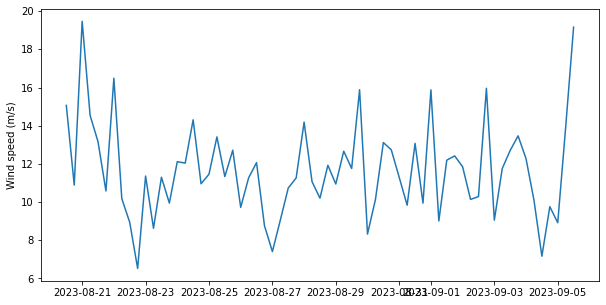

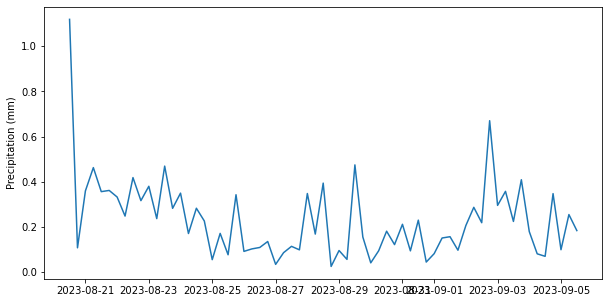

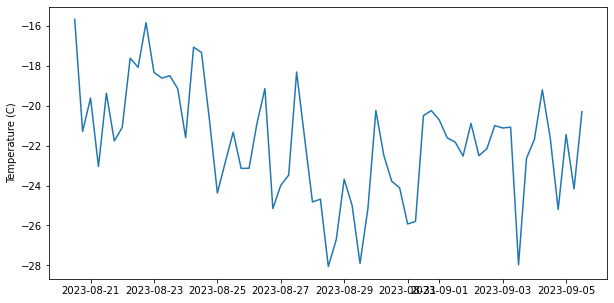

In [53]:
# If run with continuous data, uncomment here:
plt.plot(timax,co_w_con); plt.ylabel('Wind speed (m/s)'); plt.show()
plt.plot(timax,co_p_con); plt.ylabel('Precipitation (mm)'); plt.show()
plt.plot(timax,co_t_con); plt.ylabel('Temperature (C)'); plt.show()

# If run with categorical data, uncomment here:


# #Plot the final forecast -20 m/s
# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()

# ax1.plot(timax,co_cat_20,color='red',linewidth=0.01);
# ax1.fill_between(
#         x= timax, 
#         y1= co_cat_20, 
#         color= "r",
#         alpha= 0.2)
# ax1.set_ylabel("Probability of winds above 20 m/s")
# # ax1.set_ylim([0,1])

# plt.show()

# #Plot the final forecast - 30m/s
# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()


# ax1.plot(timax,co_cat_30,color='red',linewidth=0.01);
# ax1.fill_between(
#         x= timax, 
#         y1= co_cat_30, 
#         color= "r",
#         alpha= 0.2)
# ax1.set_ylabel("Probability of winds above 20 m/s")
# # ax1.set_ylim([0,1])

# plt.show()

**Step 8: Save output data to interoperable MDF files**
------------------------------------------------------------------------------------

In [234]:
# Convert all new outputs to mdf format

#Resample full data to hourly (60 minute)

#Clip off variables individually from different stations

#Attach metadata to file 

#Write MDF



data_start_date = timax.min()  
data_end_date   = timax.max() # it has been a while
    
example_MDF = MDF(supersite_name='test')

# instantiate class that will analyze and output data in MDF format
example_MDF = MDF(supersite_name='example', verbose=False)
global_atts = {
    "title"                    : "16-day forecast of winds, precipitation, and temperature at Everest Summit",
    "Conventions"              : "MDF, CF",
    "standard_name_vocabulary" : "",
    "contributor_name"         : "Max Van Wyk de Vries",
    "contributor_email"        : "maximillian.vanwykdevries@ouce.ox.ac.uk",
    "institution"              : "Kings College London",
    "creator_name"             : "Max Van Wyk de Vries",
    "creator_email"            : "maximillian.vanwykdevries@ouce.ox.ac.uk",
    "project"                  : "AtsMOS: At-scale Model Output Statistics",
    "summary"                  : "Synchronized model and observational data files from Mt Everest.",
    "id"                       : "doi tbd",
    "license"                  : "Creative Commons Attribution 4.0 License, CC 4.0", 
    "metadata_link"            : "metadata link tbd",
    "references"               : "https://doi.org/10.1175/BAMS-D-19-0198.1; https://doi.org/10.1175/BAMS-D-22-0120.1",
    "time_coverage_start"      : "2019",
    "time_coverage_end"        : "2023",
    "naming_authority"         : "___", 
    "standard_name_vocabulary" : "___", 
    "keywords"                 : "Everest, wind speed, model output statistics",
}
example_MDF.update_global_atts(global_atts)  

processed_df = pd.DataFrame({'co_w_con': co_w_con, 'co_p_con': co_p_con, 'co_t_con': co_t_con})
processed_df=processed_df.set_index(timax)

var_map_dict = { 
                'ws'            : 'co_w_con',
                'pr'            : 'co_p_con',
                'tas'           : 'co_t_con'
}


# map the names to the modf format using
print(processed_df)
modf_df = MDF.map_vars_to_mdf(processed_df, var_map_dict, drop=True) # map and drop the variables we won't be using, get new df
print("\n\n\n-------------------------------------------------------------")
print(modf_df.columns)
example_MDF.add_data_timeseries(modf_df, cadence="time60")  # specify the cadence/frequency of data provided

#example_MDF.add_df_data(processed_df, var_map_dict, cadence="time01")  # could be combined into one call


example_MDF.add_citations(var_names=modf_df.columns, citation='data product, DOI: XXXXXXXXX')

# I haven't finished the sonde code yet, sorry, :( ripping it out for now
# sonde_data = get_sonde_data()
# example_MDF.add_sonde_data(sonde_data)

# then call loop that writes the example_MDF vars to a NetCDF, must go last of course 
example_MDF.write_files(output_dir='./MDF_output/')



                      co_w_con  co_p_con   co_t_con
2023-08-20 12:00:00  15.064566  1.119312 -15.677405
2023-08-20 18:00:00  10.892645  0.107380 -21.292509
2023-08-21 00:00:00  19.465275  0.359562 -19.620554
2023-08-21 06:00:00  14.543833  0.462594 -23.047028
2023-08-21 12:00:00  13.163906  0.356191 -19.375967
...                        ...       ...        ...
2023-09-04 12:00:00   7.167778  0.069640 -21.626520
2023-09-04 18:00:00   9.762717  0.347337 -25.197351
2023-09-05 00:00:00   8.921066  0.098922 -21.449259
2023-09-05 06:00:00  13.912009  0.254662 -24.168747
2023-09-05 12:00:00  19.161304  0.183635 -20.299114

[65 rows x 3 columns]



-------------------------------------------------------------
Index(['ws', 'pr', 'tas'], dtype='object')
[]
  ... there was no time series data provided for time01 cadence
[]
  ... there was no time series data provided for time02 cadence
[]
  ... there was no time series data provided for time05 cadence
[]
  ... there was no time series data provi